In [1]:
import pandas as pd
import numpy as np
from IPython.display import display


#Dates
import itertools
from dateutil.relativedelta import relativedelta
import datetime as dt

# Stats
import math
import sidetable as stb
import scipy.stats as stats
from matplotlib import pyplot as plt



from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.io

import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

#Apriori
import mlxtend
from mlxtend.frequent_patterns import association_rules,apriori

In [2]:
try:
    data = pd.read_csv('/datasets/ecommerce_dataset_us.csv', sep= ',', parse_dates = ['InvoiceDate'])
    
except:
    data = pd.read_csv('C:/Users/Admin/Desktop/practicum/final_project/ecommerce_dataset_us.csv', sep='\t', parse_dates = ['InvoiceDate'])

In [3]:
def data_info(data):
    print('\033[1m INFO: \033[0m ')
    print(' ')
    display( data.info(memory_usage='deep'))
    print('--------------------------------------------------------------------------------------')
    print('\033[1m HEAD: \033[0m ')
    display( data.head())
    print('--------------------------------------------------------------------------------------')
    print('\033[1m DESCRIBE: \033[0m ')
    display( data.describe())
    print('--------------------------------------------------------------------------------------')
    print('\033[1m MISSING VALUES: \033[0m ')
    print(' ')
    display( data.isna().sum())
    print('--------------------------------------------------------------------------------------')
    print('\033[1m DUPLICATED: \033[0m')
    print('We have {} duplicated rows!'.format(data.duplicated().sum()))

In [4]:
data_info(data)

 INFO:  
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 124.3 MB


None

--------------------------------------------------------------------------------------
 HEAD:  


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0


--------------------------------------------------------------------------------------
 DESCRIBE:  


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


--------------------------------------------------------------------------------------
 MISSING VALUES:  
 


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
dtype: int64

--------------------------------------------------------------------------------------
 DUPLICATED: 
We have 5268 duplicated rows!


### Conclusions:
1. the data consists of 541909 lines
2. there are three columns with object type - InvoiceNo, StockCode, Description    
3. Quantity is integral, UnitPrice and CustomerID float and InvoiceDate datetime
4. there are 1454 missing values in the Description column and 135080 (a lot) in the CustomerID column     
5. we have 5268 recurring rows.
6. in column Quantity strange result minimum and maximum are very big and differ only in sign. -80,995.000- min and 80,995.000 max. it is strange and requires check.
7. in the UnitPrice column, the minimum price is -11,062,060, which is very strange and requires checking. also the maximum price is very strange. 
8. there are a lot of gaps in the CustomerID column, this also requires additional checking. 
9. Rename the names of the columns to translate them into small letters. 


In [5]:
#remove unnecessary gaps at the beginning and at the end
data.columns = data.columns.str.strip()
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0


In [6]:
# Checking for duplicates
duplicates = data.duplicated()
print("Number of duplicates: ", duplicates.sum())
print("Percentage of duplicates: ", duplicates.sum() / len(data) * 100)

Number of duplicates:  5268
Percentage of duplicates:  0.9721189350979592


Less than one percent,we can safely remove

In [7]:
data = data.drop_duplicates()

len(data)

536641

## Missing and strange data
1. Let's start with the Description column
- This column stores the names of items for sale. However, we can see that there is some missing data. Let's check how many of them there are. 

In [8]:
# Count the number of missing values in each column
missing_values_count = data.isna().sum()

# Calculate the percentage of missing values in each column
missing_values_percent = (missing_values_count / len(data)) * 100

# Display the results on the screen
print("Number and percentage of missing values in each column:")
print(missing_values_count)
missing_values_percent

Number and percentage of missing values in each column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
dtype: int64


InvoiceNo       0.000000
StockCode       0.000000
Description     0.270945
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     25.163377
dtype: float64

- The Description column has less than one percent missing date, and we have no way to restore it, so let's delete the missing values. 
- The CustomerID column has more than 25% missing. We can't delete that much information, but we can't replace it either. 
- Let's check if the missing lines in both columns are the same and delete if they are. Replace the remaining missing data in the CustomerID column with 0 for further investigation. 

In [9]:
missing_values_count = data.isna().sum()
missing_values_count

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
dtype: int64

In [10]:
data['CustomerID'] = data.groupby('Description')['CustomerID'].ffill()

In [11]:
data_info(data)

 INFO:  
 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    536641 non-null  object        
 1   StockCode    536641 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     536641 non-null  int64         
 4   InvoiceDate  536641 non-null  datetime64[ns]
 5   UnitPrice    536641 non-null  float64       
 6   CustomerID   529678 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 127.2 MB


None

--------------------------------------------------------------------------------------
 HEAD:  


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0


--------------------------------------------------------------------------------------
 DESCRIBE:  


,Quantity,UnitPrice,CustomerID
count,536641.000000,536641.000000,529678.000000
mean,9.620029,4.632656,15273.240918
std,219.130156,97.233118,1718.665479
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13934.000000
50%,3.000000,2.080000,15124.000000
75%,10.000000,4.130000,16782.000000
max,80995.000000,38970.000000,18287.000000


--------------------------------------------------------------------------------------
 MISSING VALUES:  
 


InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     6963
dtype: int64

--------------------------------------------------------------------------------------
 DUPLICATED: 
We have 0 duplicated rows!


In [12]:
missing_data = data[(data['Description'].isnull())&(data['CustomerID'].isnull())]
len(missing_data)

1454

##### full compliance, we can delete these 1454 lines

In [13]:
data.dropna(subset=["Description"], inplace=True)
len(data)

535187

In [14]:
data["CustomerID"].fillna(0, inplace=True)

In [15]:
missing_values_count = data.isna().sum()
missing_values_count

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
dtype: int64

##### we successfully got rid of the missing data.

In [16]:
data['CustomerID'] = data['CustomerID'].astype('int64')

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535187 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    535187 non-null  object        
 1   StockCode    535187 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     535187 non-null  int64         
 4   InvoiceDate  535187 non-null  datetime64[ns]
 5   UnitPrice    535187 non-null  float64       
 6   CustomerID   535187 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 32.7+ MB


##### check "UnitPrice = 0"

In [18]:
data_unit_price_0 =  data[data['UnitPrice'] == 0]
data_unit_price_0

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
6391,536941,22734,amazon,20,2018-12-01 12:08:00,0.0,0
6392,536942,22139,amazon,15,2018-12-01 12:08:00,0.0,0
7313,537032,21275,?,-30,2018-12-01 16:50:00,0.0,0
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2018-12-03 14:02:00,0.0,12647
13217,537425,84968F,check,-20,2018-12-04 15:35:00,0.0,0
...,...,...,...,...,...,...,...
535336,581213,22576,check,-30,2019-12-05 18:38:00,0.0,0
536908,581226,23090,missing,-338,2019-12-06 09:56:00,0.0,0
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2019-12-06 13:58:00,0.0,17266
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2019-12-06 13:58:00,0.0,17266


##### Since the price of the product determines the final profit or loss, and we see 1056 rows with price = 0, these rows have no effect on the final profit or loss. Perhaps there was a processing error. In any case, there are very few of them, and we can remove them without further problems for analysis. 

In [19]:
data = data.drop(data[data["UnitPrice"] == 0].index)
len(data)

534131

In [20]:
#Check the negative data in the Quantity column
data_Quantity_0 =  data[data['Quantity'] < 0]
data_Quantity_0

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
141,C536379,D,Discount,-1,2018-11-29 09:41:00,27.50,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2018-11-29 09:49:00,4.65,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2018-11-29 10:24:00,1.65,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548
...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2019-12-07 09:57:00,0.83,14397
541541,C581499,M,Manual,-1,2019-12-07 10:28:00,224.69,15498
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2019-12-07 11:57:00,10.95,15311
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2019-12-07 11:58:00,1.25,17315


In [21]:
data_Quantity_0['Quantity'].describe()

count     9251.000000
mean       -29.787050
std       1147.997592
min     -80995.000000
25%         -6.000000
50%         -2.000000
75%         -1.000000
max         -1.000000
Name: Quantity, dtype: float64

In [22]:
c_data = data[data['InvoiceNo'].str.startswith('C')]

# Check that all values in the "Quantity" column are negative
is_negative = (c_data['Quantity'] < 0).all()

# Output the result
if is_negative:
    print('All data beginning with "C" in the "InvoiceNo" column corresponds to  negative values in the "Quantity" column.')
else:
    print('Not all data starting with "C" in the "InvoiceNo" column correspond to negative values in the "Quantity" column.')

All data beginning with "C" in the "InvoiceNo" column corresponds to  negative values in the "Quantity" column.


##### Perhaps it's a certain kind of order, or a return of an item.

##### Let us test this thesis. Let's deduct all the transactions that took place at least twice. After all, in order to return a product, you must first buy it. And let's look at a specific example.

In [23]:
# data filtering
df_filtered = data.groupby('CustomerID').filter(lambda x: x['InvoiceNo'].nunique() == 2)

# A list of unique customer IDs
customer_ids = df_filtered['CustomerID'].unique()
customer_ids

array([15350, 12855, 17547, 16995, 16754, 16634, 14589, 16658, 16596,
       14987, 15945, 12605, 17524, 16202, 16262, 14777, 14119, 13922,
       13144, 15447, 12346, 14784, 15052, 14548, 13837, 12574, 16403,
       14627, 17356, 15940, 14411, 13581, 17291, 14438, 15753, 15843,
       12401, 18084, 13893, 14935, 14371, 14520, 15397, 13973, 13261,
       16078, 15319, 15733, 14473, 16414, 15234, 15944, 12881, 16471,
       13043, 13452, 15030, 14840, 13216, 14059, 16256, 14066, 17060,
       14155, 15703, 12902, 18224, 17763, 13262, 13341, 16620, 17698,
       16769, 15178, 14536, 14886, 17701, 13781, 17492, 17409, 13962,
       13508, 17574, 18080, 13655, 15212, 16697, 16097, 17746, 17601,
       17029, 16617, 17217, 18246, 18220, 17436, 15143, 16055, 18146,
       16457, 17174, 18227, 15063, 18133, 15333, 12871, 13887, 18048,
       13227, 14682, 14647, 17715, 16323, 15124, 13062, 14453, 17531,
       16967, 15405, 16659, 16849, 15386, 14542, 13283, 17414, 17234,
       16276, 15909,

In [24]:
data[data['CustomerID'] == 15922]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
1335,536537,22277,COSMETIC BAG VINTAGE ROSE PAISLEY,36,2018-11-29 13:51:00,2.10,15922
1336,536537,22333,RETROSPOT PARTY BAG + STICKER SET,8,2018-11-29 13:51:00,1.65,15922
1337,536537,20867,PINK ROSE FABRIC MIRROR,36,2018-11-29 13:51:00,1.25,15922
1338,536537,21688,SILVER PLATE CANDLE BOWL SMALL,12,2018-11-29 13:51:00,2.95,15922
1339,536537,21694,SMALL REGAL SILVER CANDLEPOT,12,2018-11-29 13:51:00,2.95,15922
1340,536537,22183,CAKE STAND VICTORIAN FILIGREE MED,6,2018-11-29 13:51:00,6.75,15922
1341,536537,22423,REGENCY CAKESTAND 3 TIER,2,2018-11-29 13:51:00,12.75,15922
1342,536537,22798,ANTIQUE GLASS DRESSING TABLE POT,8,2018-11-29 13:51:00,2.95,15922
1343,536537,22800,ANTIQUE TALL SWIRLGLASS TRINKET POT,8,2018-11-29 13:51:00,3.75,15922
1344,536537,22801,ANTIQUE GLASS PEDESTAL BOWL,8,2018-11-29 13:51:00,3.75,15922


##### We have a client with CustomerID 15922. He has two transactions numbered 536537 and C536737. The last one is a return of two units of the product "ANTIQUE GLASS DRESSING TABLE POT", which was made the next day from the original purchase. 

## UnitPrice

In [25]:
data['UnitPrice'].describe()

count    534131.000000
mean          4.654426
std          97.460790
min      -11062.060000
25%           1.250000
50%           2.100000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

##### Let's see the min and max

In [26]:
data[data['UnitPrice'] == 38970]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
222681,C556445,M,Manual,-1,2019-06-08 15:31:00,38970.0,15098


In [27]:
data[data['UnitPrice'] == -11062.06]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
299983,A563186,B,Adjust bad debt,1,2019-08-10 14:51:00,-11062.06,0
299984,A563187,B,Adjust bad debt,1,2019-08-10 14:52:00,-11062.06,0


##### We'll deal with this strange data later

##### Back to the negative values in the column Quantity

In [28]:
cancel_orders = data[data['Quantity'] < 0].reset_index()
display(cancel_orders.head())
cancel_orders.info()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,141,C536379,D,Discount,-1,2018-11-29 09:41:00,27.50,14527
1,154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2018-11-29 09:49:00,4.65,15311
2,235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2018-11-29 10:24:00,1.65,17548
3,236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548
4,237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9251 entries, 0 to 9250
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   index        9251 non-null   int64         
 1   InvoiceNo    9251 non-null   object        
 2   StockCode    9251 non-null   object        
 3   Description  9251 non-null   object        
 4   Quantity     9251 non-null   int64         
 5   InvoiceDate  9251 non-null   datetime64[ns]
 6   UnitPrice    9251 non-null   float64       
 7   CustomerID   9251 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 578.3+ KB


In [29]:
cancel_orders  = cancel_orders.reset_index()
cancel_orders['Quantity'] = abs(cancel_orders['Quantity'])
cancel_orders

,level_0,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,0,141,C536379,D,Discount,1,2018-11-29 09:41:00,27.50,14527
1,1,154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,1,2018-11-29 09:49:00,4.65,15311
2,2,235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,12,2018-11-29 10:24:00,1.65,17548
3,3,236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,24,2018-11-29 10:24:00,0.29,17548
4,4,237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,24,2018-11-29 10:24:00,0.29,17548
...,...,...,...,...,...,...,...,...,...
9246,9246,540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,11,2019-12-07 09:57:00,0.83,14397
9247,9247,541541,C581499,M,Manual,1,2019-12-07 10:28:00,224.69,15498
9248,9248,541715,C581568,21258,VICTORIAN SEWING BOX LARGE,5,2019-12-07 11:57:00,10.95,15311
9249,9249,541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,1,2019-12-07 11:58:00,1.25,17315


In [30]:
regular_orders = data[data['Quantity'] > 0].reset_index()
display(regular_orders.head())
regular_orders.info()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850
1,1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524880 entries, 0 to 524879
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   index        524880 non-null  int64         
 1   InvoiceNo    524880 non-null  object        
 2   StockCode    524880 non-null  object        
 3   Description  524880 non-null  object        
 4   Quantity     524880 non-null  int64         
 5   InvoiceDate  524880 non-null  datetime64[ns]
 6   UnitPrice    524880 non-null  float64       
 7   CustomerID   524880 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 32.0+ MB


In [31]:
#our columns of purchased and returned goods must match on these columns
check_columns = ['CustomerID','UnitPrice','Description']

In [32]:
merged_data = regular_orders.merge(cancel_orders, on=check_columns)

merged_data

,index_x,InvoiceNo_x,StockCode_x,Description,Quantity_x,InvoiceDate_x,UnitPrice,CustomerID,level_0,index_y,InvoiceNo_y,StockCode_y,Quantity_y,InvoiceDate_y
0,6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2018-11-29 08:26:00,4.25,17850,1562,86893,C543611,21730,1,2019-02-08 14:38:00
1,64,536373,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2018-11-29 09:02:00,4.25,17850,1562,86893,C543611,21730,1,2019-02-08 14:38:00
2,81,536375,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2018-11-29 09:32:00,4.25,17850,1562,86893,C543611,21730,1,2019-02-08 14:38:00
3,295,536396,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2018-11-29 10:51:00,4.25,17850,1562,86893,C543611,21730,1,2019-02-08 14:38:00
4,432,536406,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2018-11-29 11:33:00,4.25,17850,1562,86893,C543611,21730,1,2019-02-08 14:38:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20625,540161,581469,51014C,"FEATHER PEN,COAL BLACK",12,2019-12-06 19:28:00,0.39,14606,7083,387536,C570331,51014C,1,2019-10-08 12:18:00
20626,540161,581469,51014C,"FEATHER PEN,COAL BLACK",12,2019-12-06 19:28:00,0.39,14606,7873,434069,C574026,51014C,1,2019-10-31 12:26:00
20627,540170,581469,84029E,RED WOOLLY HOTTIE WHITE HEART.,1,2019-12-06 19:28:00,4.25,14606,5923,329640,C565848,84029E,1,2019-09-05 12:48:00
20628,540171,581469,21485,RETROSPOT HEART HOT WATER BOTTLE,1,2019-12-06 19:28:00,4.95,14606,5924,329641,C565848,21485,1,2019-09-05 12:48:00


In [33]:
len(merged_data)

20630

In [34]:
# create a new list of values from columns 'index_x' and 'index_y'
drop_List = set(np.column_stack((merged_data.index_x.values, merged_data.index_y.values)).ravel())

#drop_List
#clean our data
final_data= data.query("index not in @drop_List")

In [35]:
len(final_data)

509950

In [36]:
len(data)

534131

###### The product return rate is 5.2%, which is not a lot, but on the other hand it is not a little. We can't just delete this data, but we have to keep it in mind for further analysis.

In [37]:
final_data[final_data['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
141,C536379,D,Discount,-1,2018-11-29 09:41:00,27.50,14527
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2018-11-29 10:24:00,1.65,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2018-11-29 10:24:00,0.29,17548
...,...,...,...,...,...,...,...
537496,C581305,22627,MINT KITCHEN SCALES,-1,2019-12-06 11:42:00,8.50,16933
537601,C581323,21533,RETROSPOT LARGE MILK JUG,-1,2019-12-06 11:53:00,4.25,14442
540141,C581468,21314,SMALL GLASS HEART TRINKET POT,-10,2019-12-06 19:26:00,2.10,13599
540176,C581470,23084,RABBIT NIGHT LIGHT,-4,2019-12-06 19:28:00,2.08,17924


In [38]:
final_data[final_data['UnitPrice'] == -11062.06]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
299983,A563186,B,Adjust bad debt,1,2019-08-10 14:51:00,-11062.06,0
299984,A563187,B,Adjust bad debt,1,2019-08-10 14:52:00,-11062.06,0


##### examine the unexpected data in the StockCode column

In [39]:
final_data.groupby('StockCode').mean()['UnitPrice'].nlargest(10)

StockCode
AMAZONFEE       7171.695517
CRUK             495.839375
DOT              292.546780
M                238.124760
BANK CHARGES     202.855162
22828            156.428571
22827            154.600000
22656            151.944444
22655            139.720588
22823            118.076923
Name: UnitPrice, dtype: float64

###### let's study these strange stockcodes that have a letter or symbol in them.

In [40]:
final_data[final_data['StockCode'] == 'AMAZONFEE']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
14514,C537600,AMAZONFEE,AMAZON FEE,-1,2018-12-05 12:41:00,1.00,0
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2018-12-05 15:34:00,13474.79,0
16313,C537647,AMAZONFEE,AMAZON FEE,-1,2018-12-05 15:41:00,5519.25,0
16357,C537652,AMAZONFEE,AMAZON FEE,-1,2018-12-05 15:51:00,6706.71,0
43702,C540117,AMAZONFEE,AMAZON FEE,-1,2019-01-03 09:55:00,16888.02,0
43703,C540118,AMAZONFEE,AMAZON FEE,-1,2019-01-03 09:57:00,16453.71,0
96844,C544587,AMAZONFEE,AMAZON FEE,-1,2019-02-19 15:07:00,5575.28,0
96845,C544589,AMAZONFEE,AMAZON FEE,-1,2019-02-19 15:11:00,5258.77,0
124741,C546987,AMAZONFEE,AMAZON FEE,-1,2019-03-16 12:56:00,5693.05,0
124787,C546989,AMAZONFEE,AMAZON FEE,-1,2019-03-16 12:59:00,5225.03,0


##### 18 lines, this is Amazon's payment for the site. Since we are not looking at total store profits, but only products, we can remove this data from our final data list. 

In [41]:
amazonfee_data = final_data[final_data['StockCode'] == 'AMAZONFEE']
final_data = final_data[final_data['StockCode'] != 'AMAZONFEE']
final_data.groupby('StockCode').mean()['UnitPrice'].nlargest(10)

StockCode
CRUK            495.839375
DOT             292.546780
M               238.124760
BANK CHARGES    202.855162
22828           156.428571
22827           154.600000
22656           151.944444
22655           139.720588
22823           118.076923
22826           106.513158
Name: UnitPrice, dtype: float64

In [42]:
final_data[final_data['StockCode'] == 'CRUK']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
317508,C564763,CRUK,CRUK Commission,-1,2019-08-28 10:49:00,1.60,14096
324023,C565382,CRUK,CRUK Commission,-1,2019-08-31 15:45:00,13.01,14096
333779,C566216,CRUK,CRUK Commission,-1,2019-09-07 15:17:00,15.96,14096
338848,C566565,CRUK,CRUK Commission,-1,2019-09-11 12:32:00,52.24,14096
351003,C567655,CRUK,CRUK Commission,-1,2019-09-19 14:40:00,608.66,14096
361603,C568345,CRUK,CRUK Commission,-1,2019-09-24 15:28:00,447.56,14096
372785,C569245,CRUK,CRUK Commission,-1,2019-10-01 09:57:00,361.59,14096
390002,C570487,CRUK,CRUK Commission,-1,2019-10-08 17:12:00,411.92,14096
401767,C571440,CRUK,CRUK Commission,-1,2019-10-15 13:31:00,495.98,14096
416464,C572551,CRUK,CRUK Commission,-1,2019-10-22 17:07:00,425.14,14096


##### 16 lines, this is CRUK's charge for the site. Since we are not examining total store profits, but only products, we can remove this data from our final data list. 

In [43]:
CRUK_data = final_data[final_data['StockCode'] == 'CRUK']
final_data = final_data[final_data['StockCode'] != 'CRUK']
final_data.groupby('StockCode').mean()['UnitPrice'].nlargest(10)

StockCode
DOT             292.546780
M               238.124760
BANK CHARGES    202.855162
22828           156.428571
22827           154.600000
22656           151.944444
22655           139.720588
22823           118.076923
22826           106.513158
22016            83.330000
Name: UnitPrice, dtype: float64

In [44]:
final_data[final_data['StockCode'] == 'M']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
2239,536569,M,Manual,1,2018-11-29 15:35:00,1.25,16274
2250,536569,M,Manual,1,2018-11-29 15:35:00,18.95,16274
5684,536865,M,Manual,1,2018-12-01 11:28:00,2.55,16274
6798,536981,M,Manual,2,2018-12-01 14:26:00,0.85,14723
7976,537077,M,Manual,12,2018-12-03 11:59:00,0.42,17062
...,...,...,...,...,...,...,...
531432,580956,M,Manual,4,2019-12-04 14:23:00,1.25,17841
533082,C581009,M,Manual,-1,2019-12-05 09:15:00,125.00,16971
534308,C581145,M,Manual,-1,2019-12-05 13:48:00,9.95,17490
538321,581405,M,Manual,3,2019-12-06 13:50:00,0.42,13521


##### 437 lines, it is not quite clear what this data is. It says Manual, but there are negative and positive values Quantity, apparently the negative values are the cost of developing and\or printing instructions, and the positive values are sales as a product. If so, I would remove the negative values since they don't affect product distribution, and treat the positive ones as just another store product. 

In [45]:
final_data[(final_data['StockCode'] == 'M') & (final_data['Quantity'] == -1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
14716,C537610,M,Manual,-1,2018-12-05 13:23:00,631.31,17920
14728,C537613,M,Manual,-1,2018-12-05 13:28:00,313.78,17920
23241,C538189,M,Manual,-1,2018-12-08 10:35:00,133.08,13090
28993,C538681,M,Manual,-1,2018-12-11 17:12:00,316.30,15555
28994,C538682,M,Manual,-1,2018-12-11 17:14:00,1130.90,15555
...,...,...,...,...,...,...,...
481174,C577348,M,Manual,-1,2019-11-16 15:30:00,1149.98,12603
523375,C580510,M,Manual,-1,2019-12-02 13:48:00,1.25,14456
533082,C581009,M,Manual,-1,2019-12-05 09:15:00,125.00,16971
534308,C581145,M,Manual,-1,2019-12-05 13:48:00,9.95,17490


delete those 143 lines

In [46]:
final_data.drop(final_data[(final_data['StockCode'] == 'M') & (final_data['Quantity'] == -1)].index, inplace=True)
final_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850
...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2019-12-07 12:50:00,0.85,12680
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2019-12-07 12:50:00,2.10,12680
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2019-12-07 12:50:00,4.15,12680
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2019-12-07 12:50:00,4.15,12680


In [47]:
final_data.groupby('StockCode').mean()['UnitPrice'].nlargest(10)

StockCode
DOT             292.546780
BANK CHARGES    202.855162
22828           156.428571
22827           154.600000
22656           151.944444
22655           139.720588
22823           118.076923
22826           106.513158
22016            83.330000
D                72.484545
Name: UnitPrice, dtype: float64

In [48]:
final_data[final_data['StockCode'] == '22828']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
19428,537859,22828,REGENCY MIRROR WITH SHUTTERS,1,2018-12-06 16:11:00,165.0,14030
87644,543688,22828,REGENCY MIRROR WITH SHUTTERS,2,2019-02-09 11:36:00,145.0,15270
111434,545719,22828,REGENCY MIRROR WITH SHUTTERS,2,2019-03-05 10:28:00,145.0,13344
122331,546862,22828,REGENCY MIRROR WITH SHUTTERS,1,2019-03-15 15:34:00,165.0,16216
201992,554348,22828,REGENCY MIRROR WITH SHUTTERS,1,2019-05-22 08:49:00,165.0,13523
345055,567139,22828,REGENCY MIRROR WITH SHUTTERS,1,2019-09-14 14:45:00,165.0,13563
471340,576635,22828,REGENCY MIRROR WITH SHUTTERS,2,2019-11-14 09:32:00,145.0,15269


In [49]:
final_data[final_data['StockCode'] == '22655']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2018-11-30 18:06:00,295.0,13145
28866,538662,22655,VINTAGE RED KITCHEN CABINET,2,2018-12-11 15:44:00,125.0,15159
31613,538999,22655,VINTAGE RED KITCHEN CABINET,2,2018-12-13 12:09:00,125.0,16003
31851,539016,22655,VINTAGE RED KITCHEN CABINET,2,2018-12-13 13:49:00,125.0,13418
32199,539044,22655,VINTAGE RED KITCHEN CABINET,2,2018-12-13 15:47:00,125.0,15727
36187,539440,22655,VINTAGE RED KITCHEN CABINET,2,2018-12-15 15:15:00,125.0,16607
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2019-01-08 14:57:00,295.0,17406
51674,C540652,22655,VINTAGE RED KITCHEN CABINET,-1,2019-01-08 15:04:00,265.5,17406
51675,540653,22655,VINTAGE RED KITCHEN CABINET,2,2019-01-08 15:07:00,125.0,17406
54395,540946,22655,VINTAGE RED KITCHEN CABINET,1,2019-01-10 12:43:00,125.0,12359


##### only those stocodes with a letter or symbol look suspicious. let's check them

In [50]:
data_with_chars = final_data[final_data['StockCode'].str.contains('[^0-9]')]

#counting the number of occurrences of each StockCode
counts = data_with_chars['StockCode'].value_counts()

#Selecting the 10 most common StockCodes
top_10 = counts.head(10)

#result output
top_10

85123A    2052
85099B    1994
POST      1003
85099C     909
82494L     866
85099F     785
DOT        705
84596B     525
84970S     525
84997D     477
Name: StockCode, dtype: int64

In [51]:
final_data[final_data['StockCode'] == '85123A']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 09:02:00,2.55,17850
66,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 09:32:00,2.55,17850
262,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2018-11-29 10:39:00,2.55,13408
278,536396,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 10:51:00,2.55,17850
...,...,...,...,...,...,...,...
539342,581439,85123A,CREAM HANGING HEART T-LIGHT HOLDER,1,2019-12-06 16:30:00,5.79,13798
539979,581452,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2019-12-06 18:03:00,2.55,17675
540217,581472,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2019-12-06 19:55:00,2.95,15796
540837,581492,85123A,CREAM HANGING HEART T-LIGHT HOLDER,3,2019-12-07 10:03:00,5.79,13798


In [52]:
final_data[final_data['StockCode'] == '84970S']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
1990,536551,84970S,HANGING HEART ZINC T-LIGHT HOLDER,2,2018-11-29 14:34:00,0.85,17346
2975,536592,84970S,HANGING HEART ZINC T-LIGHT HOLDER,1,2018-11-29 17:06:00,2.13,17346
3152,536604,84970S,HANGING HEART ZINC T-LIGHT HOLDER,12,2018-11-30 08:43:00,0.85,14741
4960,536833,84970S,HANGING HEART ZINC T-LIGHT HOLDER,12,2018-11-30 17:48:00,0.85,18239
6099,536876,84970S,HANGING HEART ZINC T-LIGHT HOLDER,1,2018-12-01 11:36:00,2.13,18239
...,...,...,...,...,...,...,...
529950,580759,84970S,HANGING HEART ZINC T-LIGHT HOLDER,12,2019-12-04 10:30:00,0.85,17593
530207,580830,84970S,HANGING HEART ZINC T-LIGHT HOLDER,24,2019-12-04 11:38:00,0.85,14825
536778,581219,84970S,HANGING HEART ZINC T-LIGHT HOLDER,2,2019-12-06 09:28:00,2.08,14825
539328,581439,84970S,HANGING HEART ZINC T-LIGHT HOLDER,2,2019-12-06 16:30:00,2.08,14825


##### look like normal products. let's check only those that contain only letters and/ or symbols without numbers

In [53]:
import re
data_with_chars_only = final_data[final_data['StockCode'].str.match('[^\d]+')]

#selection of unique values of the StockCode column
unique_stock_codes = data_with_chars_only['StockCode'].unique()

#result output
unique_stock_codes

<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
C:\Users\Admin\AppData\Local\Temp\ipykernel_4844\4042513637.py:2: DeprecationWarning: invalid escape sequence \d
  data_with_chars_only = final_data[final_data['StockCode'].str.match('[^\d]+')]


array(['D', 'POST', 'DOT', 'M', 'BANK CHARGES', 'S', 'C2', 'DCGS0076',
       'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm', 'gift_0001_50',
       'gift_0001_30', 'gift_0001_20', 'DCGS0069', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'B'], dtype=object)

In [54]:
final_data[final_data['StockCode'] == 'B']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
299982,A563185,B,Adjust bad debt,1,2019-08-10 14:50:00,11062.06,0
299983,A563186,B,Adjust bad debt,1,2019-08-10 14:51:00,-11062.06,0
299984,A563187,B,Adjust bad debt,1,2019-08-10 14:52:00,-11062.06,0


##### remove, and at the same time get rid of those strange negative values in UnitPrice

In [55]:
B_data = final_data[final_data['StockCode'] == 'B']

In [56]:
final_data = final_data[final_data['StockCode'] != 'B']

In [57]:
final_data[final_data['StockCode'] == 'S']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
14436,C537581,S,SAMPLES,-1,2018-12-05 12:03:00,12.95,0
14437,C537581,S,SAMPLES,-1,2018-12-05 12:03:00,52.00,0
96680,C544580,S,SAMPLES,-1,2019-02-19 14:25:00,5.74,0
96681,C544580,S,SAMPLES,-1,2019-02-19 14:25:00,11.08,0
96682,C544580,S,SAMPLES,-1,2019-02-19 14:25:00,5.79,0
96683,C544580,S,SAMPLES,-1,2019-02-19 14:25:00,6.70,0
96684,C544580,S,SAMPLES,-1,2019-02-19 14:25:00,8.74,0
96685,C544580,S,SAMPLES,-1,2019-02-19 14:25:00,9.74,0
96686,C544580,S,SAMPLES,-1,2019-02-19 14:25:00,9.99,0
96687,C544580,S,SAMPLES,-1,2019-02-19 14:25:00,20.98,0


In [58]:
SAMPLES_data = final_data[final_data['StockCode'] == 'SAMPLES']

###### delete and check for data without characters, without numbers, only letters


In [59]:
final_data = final_data[final_data['StockCode'] != 'S']

In [60]:
data_with_letters_only = final_data[final_data['StockCode'].str.match('[A-Za-z]+$')]
#selection of unique values of the StockCode column
unique_stock_codes = data_with_letters_only['StockCode'].unique()

#result output
unique_stock_codes

array(['D', 'POST', 'DOT', 'M', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS'],
      dtype=object)

##### 'm', 'DCGSSBOY', 'DCGSSGIRL' - we have already seen and studied. Let's study the rest. 

In [61]:
final_data[final_data['StockCode'] == 'POST']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
386,536403,POST,POSTAGE,1,2018-11-29 11:27:00,15.0,12791
1123,536527,POST,POSTAGE,1,2018-11-29 13:04:00,18.0,12662
5073,536840,POST,POSTAGE,1,2018-11-30 18:27:00,18.0,12738
5258,536852,POST,POSTAGE,1,2018-12-01 09:51:00,18.0,12686
5369,536861,POST,POSTAGE,3,2018-12-01 10:44:00,18.0,12427
...,...,...,...,...,...,...,...
541198,581493,POST,POSTAGE,1,2019-12-07 10:10:00,15.0,12423
541216,581494,POST,POSTAGE,2,2019-12-07 10:13:00,18.0,12518
541730,581570,POST,POSTAGE,1,2019-12-07 11:59:00,18.0,12662
541767,581574,POST,POSTAGE,2,2019-12-07 12:09:00,18.0,12526


In [62]:
POST_data = final_data[final_data['StockCode'] == 'POST']

In [63]:
final_data = final_data[final_data['StockCode'] != 'POST']

In [64]:
final_data[final_data['StockCode'] == 'D']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
141,C536379,D,Discount,-1,2018-11-29 09:41:00,27.50,14527
9038,C537164,D,Discount,-1,2018-12-03 13:21:00,29.29,14527
14498,C537597,D,Discount,-1,2018-12-05 12:34:00,281.00,15498
19392,C537857,D,Discount,-1,2018-12-06 16:00:00,267.12,17340
31134,C538897,D,Discount,-1,2018-12-13 09:14:00,5.76,16422
...,...,...,...,...,...,...,...
479868,C577227,D,Discount,-1,2019-11-16 12:06:00,19.82,14527
479869,C577227,D,Discount,-1,2019-11-16 12:06:00,16.76,14527
493613,C578239,D,Discount,-1,2019-11-21 12:29:00,26.33,14912
516221,C579884,D,Discount,-1,2019-11-28 17:34:00,20.53,14527


##### some discount. let's save it in a separate variable for further analysis, and remove it from the final data 

In [65]:
D_data = final_data[final_data['StockCode'] == 'D']
final_data = final_data[final_data['StockCode'] != 'D']

In [66]:
final_data[final_data['StockCode'] == 'DOT']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
1814,536544,DOT,DOTCOM POSTAGE,1,2018-11-29 14:32:00,569.77,0
3041,536592,DOT,DOTCOM POSTAGE,1,2018-11-29 17:06:00,607.49,0
5450,536862,DOT,DOTCOM POSTAGE,1,2018-12-01 11:13:00,254.43,0
5545,536864,DOT,DOTCOM POSTAGE,1,2018-12-01 11:27:00,121.06,0
5685,536865,DOT,DOTCOM POSTAGE,1,2018-12-01 11:28:00,498.47,0
...,...,...,...,...,...,...,...
536834,581219,DOT,DOTCOM POSTAGE,1,2019-12-06 09:28:00,1008.96,14096
537254,581238,DOT,DOTCOM POSTAGE,1,2019-12-06 10:53:00,1683.75,14096
539368,581439,DOT,DOTCOM POSTAGE,1,2019-12-06 16:30:00,938.59,14096
540908,581492,DOT,DOTCOM POSTAGE,1,2019-12-07 10:03:00,933.17,14096


###### It looks like an email payment. Let's save it to a variable and delete it.

In [67]:
DOT_data = final_data[final_data['StockCode'] == 'DOT']
final_data = final_data[final_data['StockCode'] != 'DOT']

In [68]:
final_data[final_data['StockCode'] == 'PADS']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2019-04-13 09:27:00,0.001,13952
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2019-07-24 10:13:00,0.001,15618
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2019-09-23 14:58:00,0.001,16198


In [69]:
final_data[final_data['StockCode'] == 'BANK CHARGES']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
4406,536779,BANK CHARGES,Bank Charges,1,2018-11-30 15:08:00,15.000,15823
14435,C537572,BANK CHARGES,Bank Charges,-1,2018-12-05 12:00:00,95.380,15823
28992,C538680,BANK CHARGES,Bank Charges,-1,2018-12-11 17:10:00,966.920,15823
62508,541505,BANK CHARGES,Bank Charges,1,2019-01-16 15:58:00,15.000,15939
64573,C541653,BANK CHARGES,Bank Charges,-1,2019-01-18 11:50:00,1050.150,15939
90558,C544049,BANK CHARGES,Bank Charges,-1,2019-02-13 12:39:00,566.370,15939
96675,C544575,BANK CHARGES,Bank Charges,-1,2019-02-19 13:58:00,134.760,15939
96676,C544576,BANK CHARGES,Bank Charges,-1,2019-02-19 14:01:00,149.160,15939
96715,C544584,BANK CHARGES,Bank Charges,-1,2019-02-19 14:52:00,109.840,15939
112233,C545887,BANK CHARGES,Bank Charges,-1,2019-03-05 15:54:00,326.680,15939


###### Bank commission. Let's save it to a variable and delete it. 

In [70]:
bank_data = final_data[final_data['StockCode'] == 'BANK CHARGES']
final_data = final_data[final_data['StockCode'] != 'BANK CHARGES']

In [71]:
len(final_data)

507877

In [72]:
len(data)

534131

In [73]:
del_data = (len(final_data) * 100) / len(data)
del_data

95.08472640606892

##### Let's create a separate database for deleted "strange" values for possible separate analysis. 

In [74]:
str_data = pd.concat([bank_data, DOT_data, D_data, POST_data, SAMPLES_data, B_data, CRUK_data, amazonfee_data])
str_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
4406,536779,BANK CHARGES,Bank Charges,1,2018-11-30 15:08:00,15.00,15823
14435,C537572,BANK CHARGES,Bank Charges,-1,2018-12-05 12:00:00,95.38,15823
28992,C538680,BANK CHARGES,Bank Charges,-1,2018-12-11 17:10:00,966.92,15823
62508,541505,BANK CHARGES,Bank Charges,1,2019-01-16 15:58:00,15.00,15939
64573,C541653,BANK CHARGES,Bank Charges,-1,2019-01-18 11:50:00,1050.15,15939
...,...,...,...,...,...,...,...
429249,C573550,AMAZONFEE,AMAZON FEE,-1,2019-10-29 13:32:00,2185.04,0
446434,C574897,AMAZONFEE,AMAZON FEE,-1,2019-11-05 15:03:00,5877.18,0
446533,C574902,AMAZONFEE,AMAZON FEE,-1,2019-11-05 15:21:00,8286.22,0
524601,C580604,AMAZONFEE,AMAZON FEE,-1,2019-12-03 11:35:00,11586.50,0


In [75]:
final_data['Revenue'] = final_data['Quantity'] * final_data['UnitPrice']
final_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850,15.30
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850,20.34


In [76]:
final_data.describe()

,Quantity,UnitPrice,CustomerID,Revenue
count,507877.000000,507877.000000,507877.000000,507877.000000
mean,9.921680,3.294699,15160.414742,18.244176
std,38.135875,7.663739,2200.583857,82.161498
min,-9360.000000,0.001000,0.000000,-3315.000000
25%,1.000000,1.250000,13895.000000,3.750000
50%,3.000000,2.080000,15120.000000,9.870000
75%,10.000000,4.130000,16782.000000,17.400000
max,4300.000000,2500.000000,18287.000000,38970.000000


##### Let's check the min Quantity value

In [77]:
final_data[final_data['Quantity'] == -9360.000000]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2018-11-30 14:23:00,0.03,15838,-280.8


In [78]:
strange_data = final_data[final_data['CustomerID'] == 15838]
strange_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2018-11-30 14:23:00,0.03,15838,-280.80
14269,537476,22379,RECYCLING BAG RETROSPOT,150,2018-12-05 11:26:00,1.85,15838,277.50
14270,537476,22381,TOY TIDY PINK POLKADOT,100,2018-12-05 11:26:00,1.85,15838,185.00
14271,537476,85099B,JUMBO BAG RED RETROSPOT,300,2018-12-05 11:26:00,1.65,15838,495.00
15321,537638,22379,RECYCLING BAG RETROSPOT,4,2018-12-05 15:28:00,4.21,15838,16.84
...,...,...,...,...,...,...,...,...
506976,579163,22633,HAND WARMER UNION JACK,96,2019-11-26 13:59:00,1.79,15838,171.84
506977,579163,22759,SET OF 3 NOTEBOOKS IN PARCEL,144,2019-11-26 13:59:00,1.45,15838,208.80
506978,579164,22866,HAND WARMER SCOTTY DOG DESIGN,96,2019-11-26 14:00:00,1.85,15838,177.60
506979,579164,22865,HAND WARMER OWL DESIGN,36,2019-11-26 14:00:00,1.79,15838,64.44


In [79]:
strange_data[strange_data['Description'] == 'ROTATING SILVER ANGELS T-LIGHT HLDR']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2018-11-30 14:23:00,0.03,15838,-280.8


##### The customer with number 15838 made many purchases, but only one with a very strange amount (-9360). This is not a return of unnecessary goods, as this customer did not buy such a product. I will delete that line. 

In [80]:
final_data = final_data[final_data['Quantity'] != -9360]
final_data['Quantity'].describe()

count    507876.000000
mean          9.940129
std          35.797755
min       -1350.000000
25%           1.000000
50%           3.000000
75%          10.000000
max        4300.000000
Name: Quantity, dtype: float64

In [81]:
final_data[final_data['Quantity'] == -1350]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
187609,C552995,M,Manual,-1350,2019-05-10 15:19:00,0.16,18133,-216.0


In [82]:
strange_data_1 = final_data[final_data['CustomerID'] == 18133]
strange_data_1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
185919,552833,23167,SMALL CERAMIC TOP STORAGE JAR,1350,2019-05-09 14:14:00,0.69,18133,931.5
187609,C552995,M,Manual,-1350,2019-05-10 15:19:00,0.16,18133,-216.0


###### very strange result, on the one hand the only order of this client in the first line. On the other - a day later, the same number of items returned, but at a different price. Perhaps this is an error in the data or, some discount, and then by mistake recorded in StockCode M. We will not delete these lines. 
###### Let's check the distribution of the data in the Quantity column on the graph. 

In [83]:
# Let's write a function for the distribution graph
def distribution(df, column, xlabel, title):
    
    # where df is the dataset that contains the desired column; column is the name of the column with the data;
    # xlabel - X-axis caption (index); title - index in the graph name (in the Parenthetical case)
    
    fig, ax = plt.subplots(figsize=(14,5))
    plt.xlabel(xlabel)
    plt.ylabel('distribution density')
    plt.title('distribution '+title)
    
    sns.kdeplot(df[column], shade=True)
    
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    plt.show()

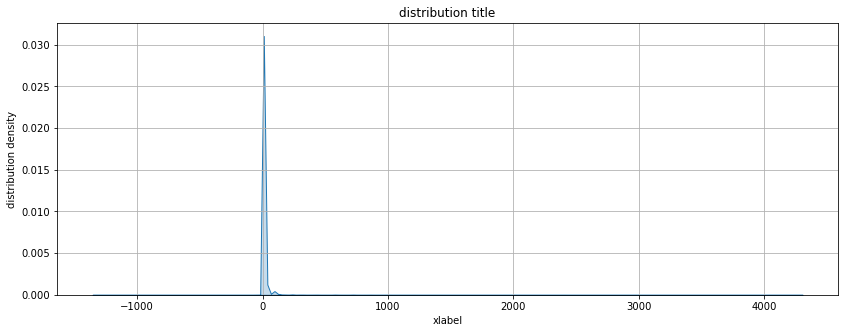

In [84]:
distribution(final_data, 'Quantity', 'xlabel', 'title')

##### consider abnormally low negative values.

In [85]:
final_low = final_data[final_data['Quantity'] <= -100]
final_low

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
4854,C536812,22574,HEART WOODEN CHRISTMAS DECORATION,-192,2018-11-30 16:58:00,0.72,16546,-138.24
4855,C536812,22593,CHRISTMAS GINGHAM STAR,-144,2018-11-30 16:58:00,0.72,16546,-103.68
4856,C536812,22595,CHRISTMAS GINGHAM HEART,-144,2018-11-30 16:58:00,0.72,16546,-103.68
4857,C536812,22588,CARD HOLDER GINGHAM HEART,-192,2018-11-30 16:58:00,2.10,16546,-403.20
4858,C536812,22130,PARTY CONE CHRISTMAS DECORATION,-144,2018-11-30 16:58:00,0.72,16546,-103.68
21699,C538110,21232,STRAWBERRY CERAMIC TRINKET BOX,-144,2018-12-07 15:24:00,1.06,17307,-152.64
43663,C540109,85071A,BLUE CHARLIE+LOLA PERSONAL DOORSIGN,-150,2019-01-02 17:12:00,2.95,17389,-442.50
77073,C542693,15036,ASSORTED COLOURS SILK FAN,-600,2019-01-29 12:36:00,0.65,12908,-390.00
86950,C543624,M,Manual,-200,2019-02-08 15:33:00,0.41,12931,-82.00
122282,C546859,M,Manual,-102,2019-03-15 14:39:00,5.45,17603,-555.90


##### check low values with strange StockCode and Description

In [86]:
strange_data_2 = final_data[final_data['CustomerID'] == 12931]
strange_data_2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
34302,539332,22197,SMALL POPCORN HOLDER,200,2018-12-15 09:45:00,0.72,12931,144.00
34989,539434,22197,SMALL POPCORN HOLDER,5,2018-12-15 14:41:00,1.66,12931,8.30
35382,539436,22197,SMALL POPCORN HOLDER,9,2018-12-15 14:49:00,1.66,12931,14.94
35845,539437,22197,SMALL POPCORN HOLDER,36,2018-12-15 14:54:00,1.66,12931,59.76
36640,539451,22197,SMALL POPCORN HOLDER,9,2018-12-15 16:59:00,1.66,12931,14.94
...,...,...,...,...,...,...,...,...
460604,C575921,20974,12 PENCILS SMALL TUBE SKULL,-184,2019-11-09 17:01:00,0.65,12931,-119.60
476466,577021,21479,WHITE SKULL HOT WATER BOTTLE,300,2019-11-15 12:39:00,3.75,12931,1125.00
479201,577150,21479,WHITE SKULL HOT WATER BOTTLE,36,2019-11-16 09:48:00,9.13,12931,328.68
480213,577289,22197,POPCORN HOLDER,300,2019-11-16 12:39:00,0.72,12931,216.00


##### the suspicion is caused by the return of the product Manual amount -200. But it is impossible to determine what it is exactly, it is impossible to remove it. 

In [87]:
strange_data_3 = final_data[final_data['CustomerID'] == 14646]
strange_data_3

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
37952,539491,21981,PACK OF 12 WOODLAND TISSUES,12,2018-12-18 10:09:00,0.29,14646,3.48
37953,539491,21986,PACK OF 12 PINK POLKADOT TISSUES,12,2018-12-18 10:09:00,0.29,14646,3.48
37954,539491,22720,SET OF 3 CAKE TINS PANTRY DESIGN,2,2018-12-18 10:09:00,4.95,14646,9.90
37955,539491,21931,JUMBO STORAGE BAG SUKI,1,2018-12-18 10:09:00,1.95,14646,1.95
37956,539491,22613,PACK OF 20 SPACEBOY NAPKINS,2,2018-12-18 10:09:00,0.85,14646,1.70
...,...,...,...,...,...,...,...,...
540933,581492,22549,PICTURE DOMINOES,3,2019-12-07 10:03:00,3.29,14646,9.87
541097,581492,23112,PARISIENNE CURIO CABINET,1,2019-12-07 10:03:00,14.96,14646,14.96
541277,581497,21671,RED SPOT CERAMIC DRAWER KNOB,1,2019-12-07 10:23:00,3.29,14646,3.29
541394,581498,22175,PINK OWL SOFT TOY,1,2019-12-07 10:26:00,5.79,14646,5.79


In [88]:
strange_data_2[strange_data_2['Description'] == '12 PENCILS SMALL TUBE SKULL']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
291234,562439,20974,12 PENCILS SMALL TUBE SKULL,480,2019-08-02 18:06:00,0.55,12931,264.00
292386,562553,20974,12 PENCILS SMALL TUBE SKULL,1,2019-08-03 16:34:00,1.25,12931,1.25
298936,563074,20974,12 PENCILS SMALL TUBE SKULL,480,2019-08-09 15:58:00,0.55,12931,264.00
319919,C564940,20974,12 PENCILS SMALL TUBE SKULL,-334,2019-08-29 13:10:00,0.65,12931,-217.10
373592,569334,20974,12 PENCILS SMALL TUBE SKULL,16,2019-10-01 13:53:00,0.55,12931,8.80
452366,575335,20974,12 PENCILS SMALL TUBE SKULL,384,2019-11-07 13:56:00,0.55,12931,211.20
460604,C575921,20974,12 PENCILS SMALL TUBE SKULL,-184,2019-11-09 17:01:00,0.65,12931,-119.60


###### it looks like a normal return. let's keep checking

In [89]:
final_low.sort_values(by='Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
187609,C552995,M,Manual,-1350,2019-05-10 15:19:00,0.16,18133,-216.00
160142,C550456,47566B,TEA TIME PARTY BUNTING,-1300,2019-04-16 13:08:00,2.55,15749,-3315.00
392671,C570708,M,Manual,-600,2019-10-10 10:11:00,0.19,12908,-114.00
77073,C542693,15036,ASSORTED COLOURS SILK FAN,-600,2019-01-29 12:36:00,0.65,12908,-390.00
319804,C564899,M,Manual,-480,2019-08-29 11:31:00,0.22,14646,-105.60
319919,C564940,20974,12 PENCILS SMALL TUBE SKULL,-334,2019-08-29 13:10:00,0.65,12931,-217.10
86950,C543624,M,Manual,-200,2019-02-08 15:33:00,0.41,12931,-82.00
4854,C536812,22574,HEART WOODEN CHRISTMAS DECORATION,-192,2018-11-30 16:58:00,0.72,16546,-138.24
4857,C536812,22588,CARD HOLDER GINGHAM HEART,-192,2018-11-30 16:58:00,2.10,16546,-403.20
460604,C575921,20974,12 PENCILS SMALL TUBE SKULL,-184,2019-11-09 17:01:00,0.65,12931,-119.60


In [90]:
strange_data_4 = final_data[final_data['CustomerID'] == 16689]
strange_data_4.sort_values(by='Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
358250,C568138,M,Manual,-144,2019-09-23 10:43:00,0.36,16689,-51.84
351261,567665,22043,CHRISTMAS CARD SCREEN PRINT,1,2019-09-19 15:22:00,0.42,16689,0.42
363612,568567,72799E,IVORY PILLAR CANDLE SILVER FLOCK,1,2019-09-25 18:41:00,3.29,16689,3.29
345673,567173,23094,LE GRAND TRAY CHIC SET,2,2019-09-16 13:29:00,12.50,16689,25.00
358478,568150,22624,IVORY KITCHEN SCALES,4,2019-09-23 11:39:00,8.50,16689,34.00
345675,567173,22561,WOODEN SCHOOL COLOURING SET,6,2019-09-16 13:29:00,1.65,16689,9.90
345671,567173,72799F,IVORY PILLAR CANDLE GOLD FLOCK,12,2019-09-16 13:29:00,2.95,16689,35.40
345672,567173,72799E,IVORY PILLAR CANDLE SILVER FLOCK,12,2019-09-16 13:29:00,2.95,16689,35.40
358479,568150,20749,ASSORTED COLOUR MINI CASES,12,2019-09-23 11:39:00,6.35,16689,76.20
345668,567173,23103,JINGLE BELL HEART DECORATION,24,2019-09-16 13:29:00,1.65,16689,39.60


###### in lines 358250 and 345666 there is a clear overlap of purchase and subsequent return. you can delete these lines

In [91]:
 final_data[final_data['CustomerID'] == 16689]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
345666,567173,22043,CHRISTMAS CARD SCREEN PRINT,144,2019-09-16 13:29:00,0.36,16689,51.84
345668,567173,23103,JINGLE BELL HEART DECORATION,24,2019-09-16 13:29:00,1.65,16689,39.60
345670,567173,20981,12 PENCILS TALL TUBE WOODLAND,24,2019-09-16 13:29:00,0.85,16689,20.40
345671,567173,72799F,IVORY PILLAR CANDLE GOLD FLOCK,12,2019-09-16 13:29:00,2.95,16689,35.40
345672,567173,72799E,IVORY PILLAR CANDLE SILVER FLOCK,12,2019-09-16 13:29:00,2.95,16689,35.40
345673,567173,23094,LE GRAND TRAY CHIC SET,2,2019-09-16 13:29:00,12.50,16689,25.00
345674,567173,21287,SCENTED VELVET LOUNGE CANDLE,24,2019-09-16 13:29:00,0.38,16689,9.12
345675,567173,22561,WOODEN SCHOOL COLOURING SET,6,2019-09-16 13:29:00,1.65,16689,9.90
351261,567665,22043,CHRISTMAS CARD SCREEN PRINT,1,2019-09-19 15:22:00,0.42,16689,0.42
358250,C568138,M,Manual,-144,2019-09-23 10:43:00,0.36,16689,-51.84


In [92]:

all_indices = final_data.index


selected_indices = final_data.loc[final_data['CustomerID'] == 16689].index


indices_to_delete = list(set(all_indices) & set(selected_indices))
print(indices_to_delete)

[345666, 345668, 345670, 345671, 345672, 345673, 345674, 345675, 358250, 358478, 358479, 358480, 363612, 351261]


In [93]:
to_drop = [345666, 358250]
final_data = final_data.drop(index=to_drop)
new_to_drop = [358478, 358479, 358480]
final_data = final_data.drop(index=new_to_drop)

In [94]:
strange_data_4 = final_data[final_data['CustomerID'] == 16689]
strange_data_4.sort_values(by='Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
351261,567665,22043,CHRISTMAS CARD SCREEN PRINT,1,2019-09-19 15:22:00,0.42,16689,0.42
363612,568567,72799E,IVORY PILLAR CANDLE SILVER FLOCK,1,2019-09-25 18:41:00,3.29,16689,3.29
345673,567173,23094,LE GRAND TRAY CHIC SET,2,2019-09-16 13:29:00,12.50,16689,25.00
345675,567173,22561,WOODEN SCHOOL COLOURING SET,6,2019-09-16 13:29:00,1.65,16689,9.90
345671,567173,72799F,IVORY PILLAR CANDLE GOLD FLOCK,12,2019-09-16 13:29:00,2.95,16689,35.40
345672,567173,72799E,IVORY PILLAR CANDLE SILVER FLOCK,12,2019-09-16 13:29:00,2.95,16689,35.40
345668,567173,23103,JINGLE BELL HEART DECORATION,24,2019-09-16 13:29:00,1.65,16689,39.60
345670,567173,20981,12 PENCILS TALL TUBE WOODLAND,24,2019-09-16 13:29:00,0.85,16689,20.40
345674,567173,21287,SCENTED VELVET LOUNGE CANDLE,24,2019-09-16 13:29:00,0.38,16689,9.12


###### Successfully deleted, we will continue checking, but this time with negative data close to zero, step by step and see how many of these products and the total loss.

In [95]:
final_low_high = final_data[(final_data['Quantity'] > -2) & (final_data['Quantity'] < 1)]
final_low_high

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
1441,C536543,22632,HAND WARMER RED RETROSPOT,-1,2018-11-29 14:30:00,2.10,17841,-2.10
1977,C536548,22654,DELUXE SEWING KIT,-1,2018-11-29 14:33:00,5.95,12472,-5.95
1985,C536548,20957,PORCELAIN HANGING BELL SMALL,-1,2018-11-29 14:33:00,1.45,12472,-1.45
4306,C536760,22175,PINK OWL SOFT TOY,-1,2018-11-30 14:29:00,2.95,17547,-2.95
4837,C536807,22778,GLASS CLOCHE SMALL,-1,2018-11-30 16:45:00,3.95,15834,-3.95
...,...,...,...,...,...,...,...,...
532722,C580989,22331,WOODLAND PARTY BAG + STICKER SET,-1,2019-12-04 16:42:00,1.65,12709,-1.65
533691,C581100,22946,WOODEN ADVENT CALENDAR CREAM,-1,2019-12-05 11:44:00,16.95,14534,-16.95
533864,C581121,22526,WHEELBARROW FOR CHILDREN,-1,2019-12-05 12:28:00,12.75,14087,-12.75
537496,C581305,22627,MINT KITCHEN SCALES,-1,2019-12-06 11:42:00,8.50,16933,-8.50


In [96]:
final_low_high['Revenue'].sum()

-3383.82

In [97]:
final_data['Revenue'].sum()

9265949.713000001

In [98]:
final_low_2_3 = final_data[(final_data['Quantity'] >= -4) & (final_data['Quantity'] <= -2)]
final_low_2_3

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
1978,C536548,22767,TRIPLE PHOTO FRAME CORNICE,-2,2018-11-29 14:33:00,9.95,12472,-19.90
1984,C536548,21218,RED SPOTTY BISCUIT TIN,-3,2018-11-29 14:33:00,3.75,12472,-11.25
1986,C536548,22580,ADVENT CALENDAR GINGHAM SACK,-4,2018-11-29 14:33:00,5.95,12472,-23.80
4307,C536760,22273,FELTCRAFT DOLL MOLLY,-3,2018-11-30 14:29:00,2.95,17547,-8.85
4876,C536814,21527,RED RETROSPOT TRADITIONAL TEAPOT,-2,2018-11-30 17:03:00,7.95,13958,-15.90
...,...,...,...,...,...,...,...,...
531799,C580968,23534,WALL ART STOP FOR TEA,-4,2019-12-04 14:57:00,5.95,15622,-23.80
531800,C580968,23534,WALL ART STOP FOR TEA,-3,2019-12-04 14:57:00,5.95,15622,-17.85
531802,C580968,23526,WALL ART DOG LICENCE,-4,2019-12-04 14:57:00,5.95,15622,-23.80
534009,C581128,85099B,JUMBO BAG RED RETROSPOT,-3,2019-12-05 12:46:00,2.08,12785,-6.24


In [99]:
final_low_0_10 = final_data[(final_data['Quantity'] >= -10) & (final_data['Quantity'] <= 0)]
final_low_0_10

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
1441,C536543,22632,HAND WARMER RED RETROSPOT,-1,2018-11-29 14:30:00,2.10,17841,-2.10
1976,C536548,22892,SET OF SALT AND PEPPER TOADSTOOLS,-7,2018-11-29 14:33:00,1.25,12472,-8.75
1977,C536548,22654,DELUXE SEWING KIT,-1,2018-11-29 14:33:00,5.95,12472,-5.95
1978,C536548,22767,TRIPLE PHOTO FRAME CORNICE,-2,2018-11-29 14:33:00,9.95,12472,-19.90
1984,C536548,21218,RED SPOTTY BISCUIT TIN,-3,2018-11-29 14:33:00,3.75,12472,-11.25
...,...,...,...,...,...,...,...,...
534310,C581145,23249,VINTAGE RED ENAMEL TRIM PLATE,-9,2019-12-05 13:48:00,1.49,17490,-13.41
537496,C581305,22627,MINT KITCHEN SCALES,-1,2019-12-06 11:42:00,8.50,16933,-8.50
537601,C581323,21533,RETROSPOT LARGE MILK JUG,-1,2019-12-06 11:53:00,4.25,14442,-4.25
540141,C581468,21314,SMALL GLASS HEART TRINKET POT,-10,2019-12-06 19:26:00,2.10,13599,-21.00


In [100]:
final_low_0_10['Revenue'].sum()

-9465.66

In [101]:
final_low_0_100 = final_data[(final_data['Quantity'] >= -100) & (final_data['Quantity'] <= 0)]
final_low_0_100

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2018-11-29 10:24:00,1.65,17548,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548,-6.96
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2018-11-29 10:24:00,0.29,17548,-6.96
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2018-11-29 10:24:00,3.45,17548,-41.40
...,...,...,...,...,...,...,...,...
534310,C581145,23249,VINTAGE RED ENAMEL TRIM PLATE,-9,2019-12-05 13:48:00,1.49,17490,-13.41
537496,C581305,22627,MINT KITCHEN SCALES,-1,2019-12-06 11:42:00,8.50,16933,-8.50
537601,C581323,21533,RETROSPOT LARGE MILK JUG,-1,2019-12-06 11:53:00,4.25,14442,-4.25
540141,C581468,21314,SMALL GLASS HEART TRINKET POT,-10,2019-12-06 19:26:00,2.10,13599,-21.00


In [102]:
final_low_0_100['Revenue'].sum()

-17939.79

In [103]:
final_data['Revenue'].sum()

9265949.713000001

In [104]:
final_low_0_100['Quantity'].sum()

-6775

In [105]:
final_data['Quantity'].sum()

5048289

In [106]:
 final_low_0_100['Quantity'].count()

1054

In [107]:
final_data['Quantity'].count()

507871

##### After studying the near-zero data, we conclude that there are quite a few of them. If we could easily identify the exact correspondence of returns to their purchases, then we would simply delete such returns. But their values for all tested indicators do not exceed 1%, I do not see the point of doing anything with this data. 

In [108]:
len(final_data)

507871

In [109]:
len(data)

534131

##### Let's study the distribution by date, more specifically by year. There is a suspicion that the data contain more than one year. 

In [110]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507871 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    507871 non-null  object        
 1   StockCode    507871 non-null  object        
 2   Description  507871 non-null  object        
 3   Quantity     507871 non-null  int64         
 4   InvoiceDate  507871 non-null  datetime64[ns]
 5   UnitPrice    507871 non-null  float64       
 6   CustomerID   507871 non-null  int64         
 7   Revenue      507871 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 34.9+ MB


###### Let's find and add the average check

In [111]:
final_data['Revenue'] = final_data['Quantity'] * final_data['UnitPrice']
Average_Check = final_data.groupby('InvoiceNo')['Revenue'].sum().reset_index()
Average_Check.head()






,InvoiceNo,Revenue
0,536365,113.62
1,536366,22.20
2,536367,253.23
3,536368,70.05
4,536369,17.85


In [112]:
Average_Check[Average_Check['InvoiceNo'] == '536365']

,InvoiceNo,Revenue
0,536365,113.62


In [113]:
# присоединение колонки с суммой выручки и средним чеком к исходной таблице
final_data = final_data.merge(Average_Check, on='InvoiceNo')
final_data['Average_Check'] = Average_Check['Revenue']

In [114]:
final_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue_x,Revenue_y,Average_Check
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850,15.30,113.62,113.62
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,22.20
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850,22.00,113.62,253.23
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,70.05
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,17.85


In [115]:
final_data = final_data.drop(['Average_Check'], axis=1)
final_data = final_data.rename(columns={'Revenue_x': 'Revenue', 'Revenue_y' : 'Average_Check'})

In [116]:
final_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue,Average_Check
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850,15.30,113.62
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850,22.00,113.62
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62


In [246]:
final_data[final_data['InvoiceNo'] == '536365']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue,Average_Check,Year,Month,Category,Season
0,536365,85123A,white hanging heart t-light holder,6,2018-11-29 08:26:00,2.55,17850,15.30,113.62,2018,11,Home,Autumn
1,536365,71053,white metal lantern,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,2018,11,Home,Autumn
2,536365,84406B,cream cupid hearts coat hanger,8,2018-11-29 08:26:00,2.75,17850,22.00,113.62,2018,11,Holidays,Autumn
3,536365,84029G,knitted union flag hot water bottle,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,2018,11,Kitchen,Autumn
4,536365,84029E,red woolly hottie white heart.,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,2018,11,Kitchen,Autumn
5,536365,22752,set 7 babushka nesting boxes,2,2018-11-29 08:26:00,7.65,17850,15.30,113.62,2018,11,Home,Autumn


In [135]:

final_data['Year'] = final_data['InvoiceDate'].dt.year


final_data['Month'] = final_data['InvoiceDate'].dt.month


data_2018 = final_data[final_data['Year'] == 2018]
data_2019 = final_data[final_data['Year'] == 2019]

In [136]:
data_2018.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue,Average_Check,Year,Month,Category
0,536365,85123A,white hanging heart t-light holder,6,2018-11-29 08:26:00,2.55,17850,15.30,113.62,2018,11,Home
1,536365,71053,white metal lantern,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,2018,11,Home
2,536365,84406B,cream cupid hearts coat hanger,8,2018-11-29 08:26:00,2.75,17850,22.00,113.62,2018,11,Holidays
3,536365,84029G,knitted union flag hot water bottle,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,2018,11,Kitchen
4,536365,84029E,red woolly hottie white heart.,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,2018,11,Kitchen


In [137]:
data_2018['Month'].unique()

array([11, 12], dtype=int64)

In [138]:
len(data_2018)

39901

In [139]:
len(data_2019)

467970

##### In the 2018 data, we have data for months 11 and 12. This data could skew our analysis if we have data for those months and in the 2019 data. 

In [140]:
data_2019['Month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

##### This year also contains data for months 11 and 12, which means our study may be skewed. I suggest that from now on we conduct analyses on the data from data_2019 and final_data and compare them.

## Conclusion
### We examined the data, eliminated the necessary data:
- some of the negative data in the Quantity column, those with a C in InvoiceNo and their matching ones in the positive Quantity, concluding that these are product returns that do not affect the distribution. 
- Missing data in Description
- obvious duplicates.
### After examining the strange values in StockCode, we identified and removed
- all values that in our opinion are irrelevant to the products. 
- we also created a separate table of such products for possible separate analysis. 
### We deleted about 5% of the data

# Product Analysis

Let's categorize the Description. Our goal is to structure product names so that there are as few groups as possible.

In [141]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507871 entries, 0 to 507870
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   InvoiceNo      507871 non-null  object        
 1   StockCode      507871 non-null  object        
 2   Description    507871 non-null  object        
 3   Quantity       507871 non-null  int64         
 4   InvoiceDate    507871 non-null  datetime64[ns]
 5   UnitPrice      507871 non-null  float64       
 6   CustomerID     507871 non-null  int64         
 7   Revenue        507871 non-null  float64       
 8   Average_Check  507871 non-null  float64       
 9   Year           507871 non-null  int64         
 10  Month          507871 non-null  int64         
 11  Category       507871 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 50.4+ MB


In [142]:
final_data.Description.unique()

array(['white hanging heart t-light holder', 'white metal lantern',
       'cream cupid hearts coat hanger', ...,
       'set 10 cards hanging baubles 17080', 'letter "u" bling key ring',
       'cream hanging heart t-light holder'], dtype=object)

In [143]:
from collections import Counter

In [144]:
final_data['Description'] = final_data['Description'].str.lower()

descriptions = final_data["Description"].unique().tolist()

# create a dictionary mapping each word to its frequency
word_freq = Counter(" ".join(descriptions).split())
sorted_counter = sorted(word_freq.items(), key=lambda x: x[1], reverse=True) 
sorted_counter

[('set', 324),
 ('pink', 300),
 ('of', 241),
 ('heart', 237),
 ('vintage', 220),
 ('blue', 215),
 ('red', 198),
 ('bag', 171),
 ('christmas', 157),
 ('glass', 154),
 ('box', 135),
 ('white', 132),
 ('design', 129),
 ('holder', 117),
 ('small', 115),
 ('flower', 115),
 ('metal', 111),
 ('large', 106),
 ('hanging', 103),
 ('green', 102),
 ('decoration', 101),
 ('rose', 100),
 ('necklace', 100),
 ('black', 98),
 ('wall', 97),
 ('retrospot', 96),
 ('3', 95),
 ('candle', 94),
 ('t-light', 89),
 ('silver', 86),
 ('paper', 85),
 ('cake', 83),
 ('with', 81),
 ('and', 80),
 ('card', 78),
 ('art', 77),
 ('garden', 72),
 ('in', 72),
 ('polkadot', 71),
 ('mug', 70),
 ('earrings', 69),
 ('bracelet', 68),
 ('ivory', 67),
 ('cover', 67),
 ('4', 67),
 ('wrap', 66),
 ('pack', 64),
 ('sign', 64),
 ('6', 63),
 ('gift', 61),
 ('mini', 61),
 ('12', 60),
 ('assorted', 59),
 ('egg', 59),
 ('star', 59),
 ('tree', 59),
 ('love', 57),
 ('tea', 56),
 ('10', 54),
 ('bowl', 53),
 ('cards', 53),
 ('cushion', 52),
 

In [145]:
main_list = {
    'Holidays':('christmas','holiday','greeting','birthday','garland', 'gift', 'decoration', 'card', 'paper',
                'wrap', 'star', 'party', 'easter', 'cards', 'birthday', 'cupid'),
    'Jewerly':('necklace','pendant', 'bracelet', 'earrings', 'ring',  
               'diamante','jewellery', 'bead', 'jewelled'),
    'Bags':('bag','wallet','pocket','handbag', 'purse', 'lunch'),
    'Home':('home','house','picture','lights','number','door','magnets','book','spot','table','drawer','key','garden',
            'holder','curtain','lantern','chandelier','lamp', 'hook', 'coat rack','bathroom','box', 'photo',
            'candles','clock','cushion','frame','mirror', 'sign','t-light','light','candle','wall','decoration',
            'design','desk','cushion', 'clock',  'heart'),
    'Kitchen':('pot','diner','food','tissues','dish','dinner','light','basket','storage','water','hot','jar',
               'ceramic','spoon','cutlery','bin','breakfast','folk','tea','plate','cup','bowl','mug',
               'holder','placemats','picnic','beakers','saucer','container', 'glass', 'bottle', 'tray', 'pan', 'kitchen'),
    'Bakery':('chocolate','cookie','milk','baking','jam','coffee','cake','pantry'),
    'Style':('vintage','victorian','edwardian','classic', 'baroque', 'antique','wood','wooden', 'flower'),
    'Toys':('dolly','mice','soldier','game','naughts','bird','kids','doll','jigsaw','toy','bunny','childrens','dolly',
            'girl','ducks','mobile','dolphins','teddy','gingham', 'spaceboy' ),
    'Cloth':('hat','poncho','sock','sombrero','hand warmer', 'umbrella'),
    'Small stuff':('cases','tube','pencils','paint','pen','plasters','sewing kit','doiley','first aid','scissor',
                    'lip gloss','rubber','tins','doily','balm','tag','doilies','magnets','silk fan', 'stamp',
                   'erasers','sponge','incense','beaker','coaster','ribbon reel','craft','led','clay','spinning')
}


newdict = {i: k for k, v in main_list.items() for i in v}

final_data['Category']=final_data.Description.str.findall('|'.join(newdict.keys())).str[0].map(newdict)

In [146]:
final_data['Category'] = final_data['Category'].replace(np.nan, 'Others')

In [147]:
final_data['Category'].value_counts()

Home           151686
Kitchen         73905
Holidays        53061
Style           46410
Small stuff     42941
Bags            42103
Bakery          29021
Others          28751
Toys            27718
Jewerly          7352
Cloth            4923
Name: Category, dtype: int64

In [148]:
data_2018 = final_data[final_data['Year'] == 2018]

In [149]:
data_2018['Category'].value_counts()

Home           12182
Kitchen         6307
Holidays        3846
Small stuff     3622
Style           3186
Others          2741
Bakery          2366
Bags            2110
Toys            2047
Cloth            807
Jewerly          687
Name: Category, dtype: int64

C:\Users\Admin\.ipython\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Admin\.ipython\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


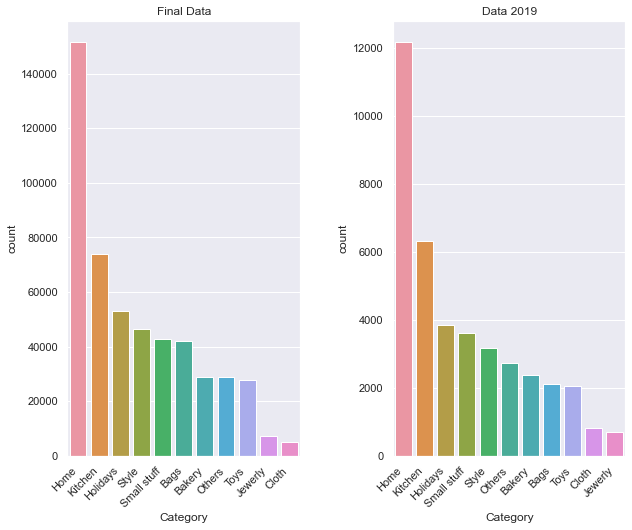

In [150]:
#graph size adjustment
sns.set(rc={"figure.figsize":(10, 8)})

# Creating a grid for placing graphs
fig, axs = plt.subplots(1, 2)

# plotting the first graph
sns.countplot(x="Category", data=final_data, order=final_data['Category'].value_counts().index, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha="right") 
axs[0].set_title('Final Data')

# plotting the second graph
sns.countplot(x="Category", data=data_2018, order=data_2018['Category'].value_counts().index, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha="right")
axs[1].set_title('Data 2019')


plt.subplots_adjust(wspace=0.4)


plt.show()

## Final_data 

In [247]:
grouped_data_Quantity = (final_data.groupby(['Category'])
              .agg({'Quantity':'sum', 'Revenue':'sum'})
              
              .sort_values(by='Revenue', ascending=False))
grouped_data_Quantity

,Quantity,Revenue
Category,,
Home,1378980,2907767.233
Kitchen,685621,1471154.990
Style,440180,925808.270
Bags,458004,864250.550
Holidays,651177,809212.400
Small stuff,500991,705926.890
Bakery,298853,633927.630
Toys,294956,453857.780
Others,207206,298976.180


C:\Users\Admin\.ipython\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Admin\.ipython\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


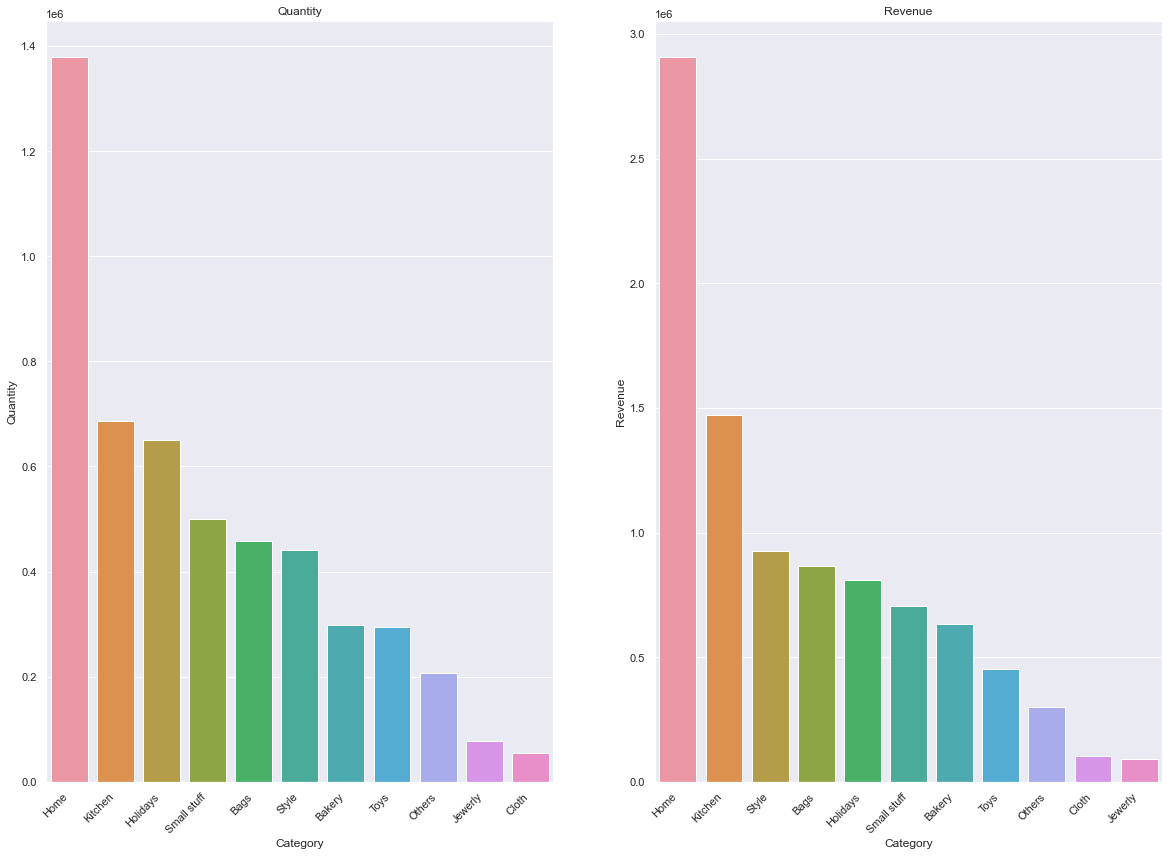

In [249]:
#graph size adjustment
sns.set(rc={"figure.figsize":(20, 14)})

# Create a list with column names
columns = ['Quantity', 'Revenue']

# Creating a grid for placing graphs
fig, axs = plt.subplots(1, 2)

# iteration by columns
for i, col in enumerate(columns):

    #grouping of data by categories
    grouped_data = (final_data.groupby(['Category'])
                    .agg({'Quantity':'sum', 'Revenue':'sum'})
                    
                    .sort_values(by=col, ascending=False))

    # plotting
    
    sns.barplot(x=grouped_data.index, y=grouped_data[col], ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha="right") 
    axs[i].set_title(col)


plt.subplots_adjust(wspace=0.2)


plt.show()


## Qantity:
 - highest number of product units sold in Home, Kitchen and Holidays categories
 - Others, Jewerly and Cloth have the least
## Revenue:
 - categories bringing in the most revenue - Home, Kitchen and Style
 - Others, Cloth and Jewerly  


## data_2018

In [250]:
grouped_data_2018 = (data_2018.groupby(['Category'])
              .agg({ 'Quantity':'sum', 'Revenue':'sum'})
              
              .sort_values(by='Revenue', ascending=False))
grouped_data_2018

,Quantity,Revenue
Category,,
Home,101080,223541.53
Kitchen,45929,133810.41
Style,26221,72593.36
Bakery,21932,62168.82
Holidays,35791,55185.87
Small stuff,34555,49240.62
Bags,17796,37228.60
Others,14878,28274.30
Toys,17751,26733.84


C:\Users\Admin\.ipython\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Admin\.ipython\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


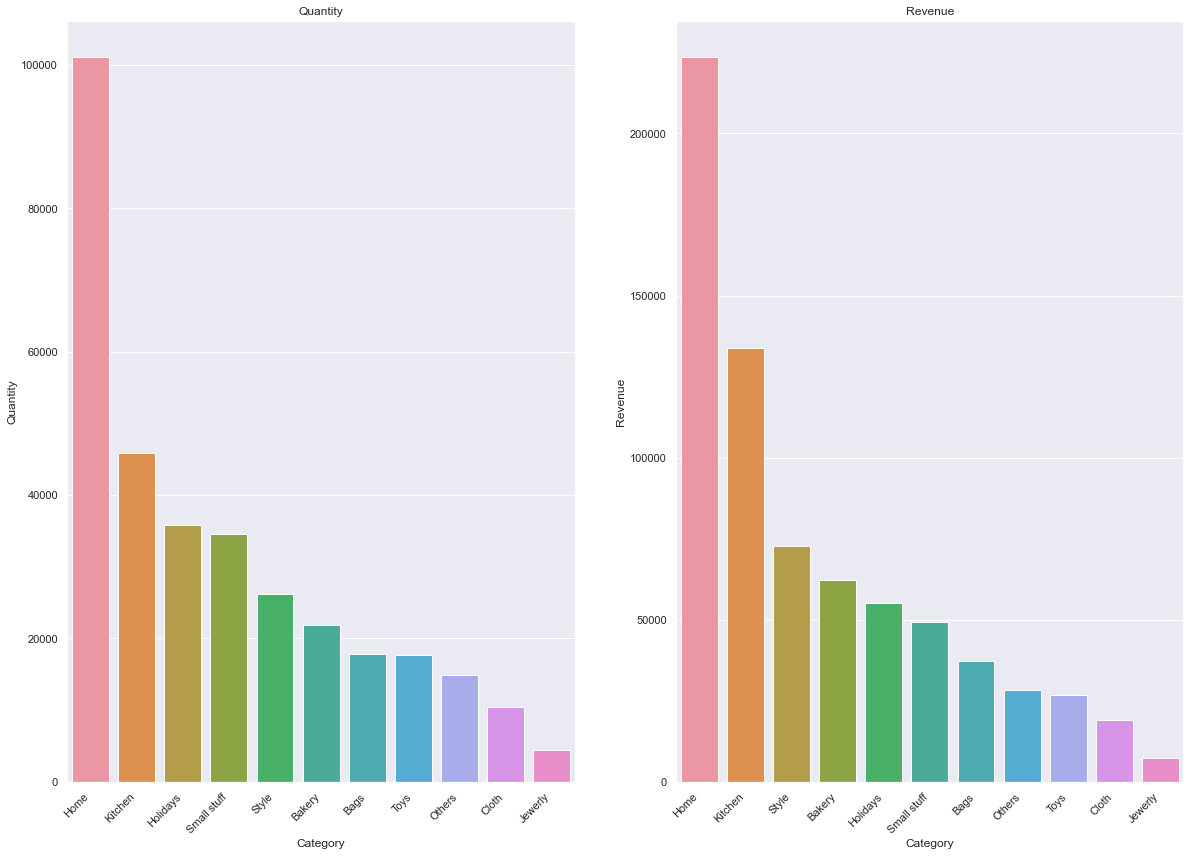

In [252]:

sns.set(rc={"figure.figsize":(20, 14)})


columns = ['Quantity', 'Revenue']


fig, axs = plt.subplots(1, 2)


for i, col in enumerate(columns):

    
    grouped_data = (data_2018.groupby(['Category'])
                    .agg({'Quantity':'sum', 'Revenue':'sum'})
                    
                    .sort_values(by=col, ascending=False))

   
    
    sns.barplot(x=grouped_data.index, y=grouped_data[col], ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha="right") 
    axs[i].set_title(col)


plt.subplots_adjust(wspace=0.2)


plt.show()

 
## Qantity:
 - highest number of product units sold in Home, Kitchen and Holidays categories
 - Others, Jewerly and Cloth have the least
## Revenue:
 - categories bringing in the most revenue - Home, Kitchen and Style
 - Others, Cloth and Jewerly  


# Conclusions: 
 - The distribution of products is very similar, between the data for 2018 only and the full data. For the first three and the last three categories, for all parameters tested. (Number of products sold, Revenue, and average check.
 - Number of products sold by category for both data slices: 
   - Highest number of units of product sold in Home, Kitchen and Holidays categories
   - Others, Jewerly and Cloth the least.
 - However, we can see that there is a slight change in the case of income and average check.   The Style category, which is right in the middle in terms of the number of products sold, ranks third among the categories in terms of income and average check. This suggests that perhaps the store should pay extra attention to this category, and perhaps increase the number of sales of these products. 
 - It's worth paying attention to the Home, Kitchen categories as sales leaders. 
 - The Cloth and Jewelly categories, which are tailgating in all respects, are also worth working on. 


# Distribution by season. 
- Remember, our database has data for November and December 2018, as well as for all of 2019. To ensure that November and December 2018 do not affect the distribution analysis, we use data for 2019 (Data_2019) and for 2018 separately, doing a distribution analysis between the 2 months. 

In [155]:
data_2019 = final_data[final_data['Year'] == 2019]

In [156]:
# Adding a season column based on the month
seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
data_2019['Season'] = data_2019['Month'].map(seasons)

# Grouping data by season and product name
seasonal_sales = data_2019.groupby(['Season', 'Category'])['Quantity'].sum().reset_index()

# Sales sorting in descending order
seasonal_sales = seasonal_sales.sort_values(by='Quantity', ascending=False)


seasonal_sales

,Season,Category,Quantity
4,Autumn,Home,470049
26,Summer,Home,298024
3,Autumn,Holidays,296187
15,Spring,Home,282062
6,Autumn,Kitchen,228720
37,Winter,Home,227765
9,Autumn,Style,189113
8,Autumn,Small stuff,180319
17,Spring,Kitchen,157859
28,Summer,Kitchen,148349


In [157]:
data_2019.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue,Average_Check,Year,Month,Category,Season
39901,539993,22386,jumbo bag pink polkadot,10,2019-01-02 10:00:00,1.95,13313,19.5,307.3,2019,1,Bags,Winter
39902,539993,21499,blue polkadot wrap,25,2019-01-02 10:00:00,0.42,13313,10.5,307.3,2019,1,Holidays,Winter
39903,539993,21498,red retrospot wrap,25,2019-01-02 10:00:00,0.42,13313,10.5,307.3,2019,1,Home,Winter
39904,539993,22379,recycling bag retrospot,5,2019-01-02 10:00:00,2.10,13313,10.5,307.3,2019,1,Bags,Winter
39905,539993,20718,red retrospot shopper bag,10,2019-01-02 10:00:00,1.25,13313,12.5,307.3,2019,1,Home,Winter


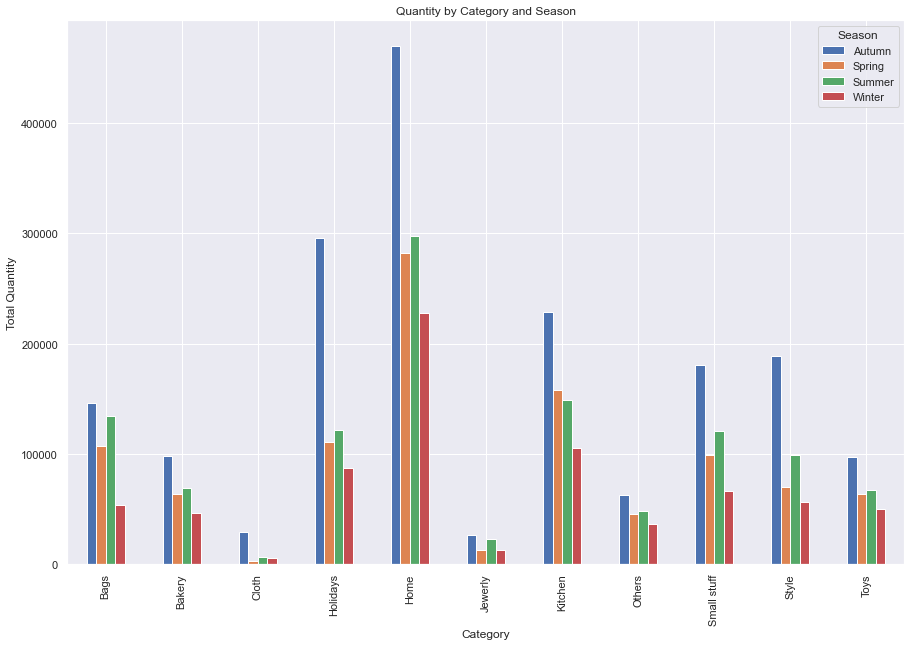

In [158]:
# Group the data by category and season and calculate the total number of sales
sales_by_category_season = data_2019.groupby(['Category', 'Season'])['Quantity'].sum()

# Create a summary table
pivot_table = pd.pivot_table(data_2019, values='Quantity', index='Category', columns='Season', aggfunc='sum')

# Visualize the results with a bar graph
pivot_table.plot(kind='bar', figsize=(15, 10))
plt.title('Quantity by Category and Season')
plt.xlabel('Category')
plt.ylabel('Total Quantity')
plt.show()

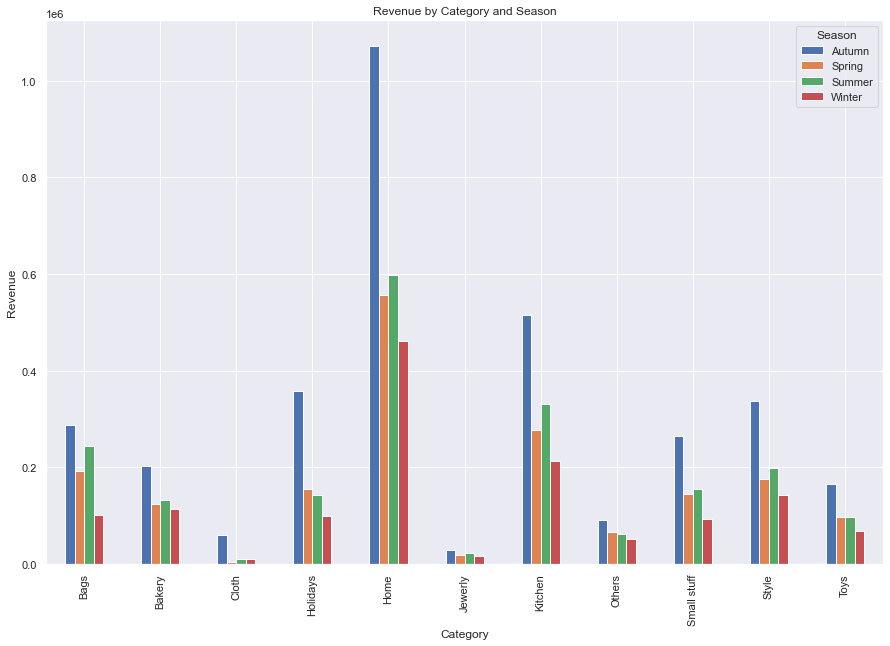

In [159]:
# Group the data by category and season and calculate the total number of sales
sales_by_category_season = data_2019.groupby(['Category', 'Season'])['Revenue'].sum()

# Create a summary table
pivot_table = pd.pivot_table(data_2019, values='Revenue', index='Category', columns='Season', aggfunc='sum')

# Visualize the results with a bar graph
pivot_table.plot(kind='bar', figsize=(15, 10))
plt.title('Revenue by Category and Season')
plt.xlabel('Category')
plt.ylabel( 'Revenue')
plt.show()

## Conclusions for 2019:
- we see that in all metrics (counts, income, and average check), Fall is doing best. By a notable margin in all categories. 
- Behind Fall sales are better in Summer
- Winter and Spring compete for the worst spots.
- It may be worthwhile for businesses to come up with additional motivators, such as discounts or promotions for customers during these seasons (Winter and Spring). 

## data_2018

In [161]:


# Grouping data by season and product name
Month_sales = data_2018.groupby(['Month', 'Category'])['Quantity'].sum().reset_index()

# Sales sorting in descending order
Month_sales = Month_sales.sort_values(by='Quantity', ascending=False)


Month_sales

,Month,Category,Quantity
15,12,Home,84198
17,12,Kitchen,39713
14,12,Holidays,30259
19,12,Small stuff,28823
20,12,Style,22757
12,12,Bakery,18784
4,11,Home,16882
11,12,Bags,15325
21,12,Toys,14343
18,12,Others,13159


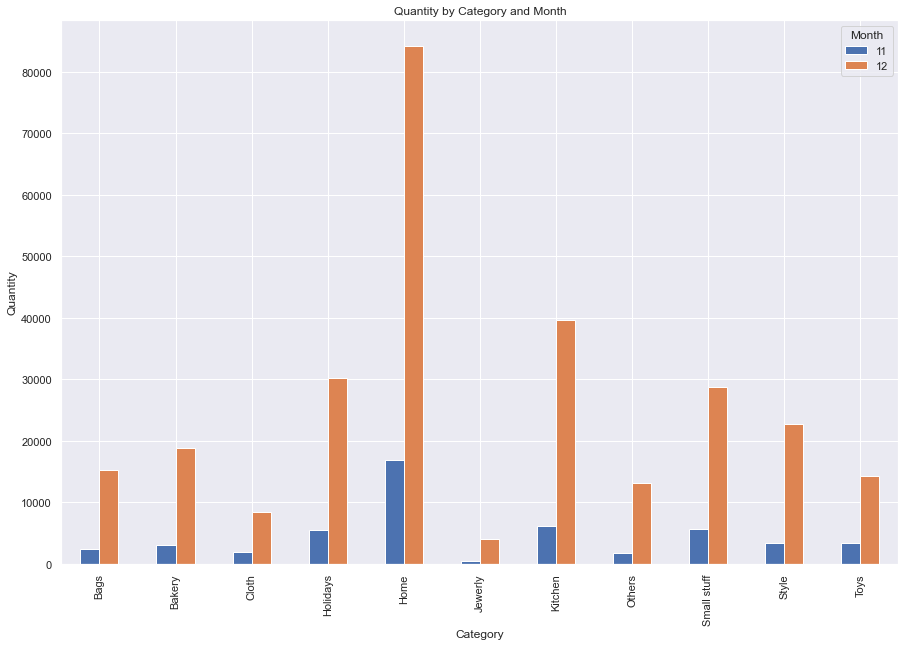

In [162]:
# Group the data by category and season and calculate the total number of sales
sales_by_category_season = data_2018.groupby(['Category', 'Month'])['Quantity'].sum()

# Create a summary table
pivot_table = pd.pivot_table(data_2018, values='Quantity', index='Category', columns='Month', aggfunc='sum')

# Visualize the results with a bar graph
pivot_table.plot(kind='bar', figsize=(15, 10))
plt.title('Quantity by Category and Month')
plt.xlabel('Category')
plt.ylabel('Quantity')
plt.show()

###### we see a huge difference between the number of sales in November and December. It's possible that sales only started in November and that's why they are so small. There is no point in examining further, and we can only draw conclusions from the 2019 data. 


## APRIORI

The Apriori function is an algorithm for analyzing associative rules, which is used to find frequent sets of items in a dataset. The algorithm works on the basis that any frequent set is a subset of some large set.

The algorithm consists of two steps:

1. Finding all frequent itemsets in the dataset that satisfy a given support threshold (min_support).
2. Generating rules from frequent sets satisfying a given confidence threshold (min_confidence).

The Apriori algorithm is one of the most widely used algorithms for data analysis, especially in marketing and sales tasks. It can be used to identify relationships between items that are often purchased together, allowing for more efficient inventory management and product distribution.

In [163]:
basket_main_country = (final_data.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket_main_country

Description,4 purple flock dinner candles,50's christmas gift bag large,dolly girl beaker,i love london mini backpack,i love london mini rucksack,nine drawer office tidy,oval wall mirror diamante,red spot gift bag large,set 2 tea towels i love london,spaceboy baby gift set,...,zinc star t-light holder,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C581145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C581305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C581323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
def apriory(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1

# Encoding the datasets
basket_encoded = basket_main_country.applymap(apriory)
basket_main_country = basket_encoded
  
basket_main_country.sample(5)

Description,4 purple flock dinner candles,50's christmas gift bag large,dolly girl beaker,i love london mini backpack,i love london mini rucksack,nine drawer office tidy,oval wall mirror diamante,red spot gift bag large,set 2 tea towels i love london,spaceboy baby gift set,...,zinc star t-light holder,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
574335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
562222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
575322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
557670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
# Building the model
frq_items = apriori(basket_main_country, min_support = 0.025, use_colnames = True, low_memory=True)
display(frq_items)

# Collecting the inferred rules in a dataframe
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
display(rules.head(10))

C:\Users\Admin\.ipython\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.047068,(6 ribbons rustic charm)
1,0.030397,(60 cake cases vintage christmas)
2,0.040230,(60 teatime fairy cake cases)
3,0.030347,(72 sweetheart fairy cake cases)
4,0.043823,(alarm clock bakelike green)
...,...,...
186,0.025505,"(lunch bag pink polkadot, lunch bag black sku..."
187,0.028051,"(lunch bag black skull., lunch bag red retros..."
188,0.027053,"(lunch bag pink polkadot, lunch bag red retros..."
189,0.025006,"(lunch bag red retrospot, lunch bag spaceboy d..."


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,(pink regency teacup and saucer),(green regency teacup and saucer),0.032543,0.044173,0.025006,0.768405,17.395472,0.023569,4.127148
9,(green regency teacup and saucer),(roses regency teacup and saucer ),0.044173,0.045770,0.031295,0.708475,15.479049,0.029273,3.273231
5,(gardeners kneeling pad cup of tea ),(gardeners kneeling pad keep calm ),0.036836,0.043773,0.025905,0.703252,16.065741,0.024292,3.222353
8,(roses regency teacup and saucer ),(green regency teacup and saucer),0.045770,0.044173,0.031295,0.683751,15.479049,0.029273,3.022392
33,(paper chain kit vintage christmas),(paper chain kit 50's christmas ),0.039930,0.056751,0.026853,0.672500,11.850077,0.024587,2.880151
14,(jumbo bag pink polkadot),(jumbo bag red retrospot),0.059097,0.098228,0.038383,0.649493,6.612092,0.032578,2.572766
3,(dolly girl lunch box),(spaceboy lunch box ),0.040429,0.043424,0.025206,0.623457,14.357422,0.023450,2.540415
10,(jumbo bag baroque black white),(jumbo bag red retrospot),0.044871,0.098228,0.027502,0.612903,6.239592,0.023094,2.329577
17,(jumbo bag woodland animals),(jumbo bag red retrospot),0.042276,0.098228,0.025805,0.610390,6.214002,0.021652,2.314548
1,(alarm clock bakelike green),(alarm clock bakelike red ),0.043823,0.046519,0.026054,0.594533,12.780546,0.024016,2.351564


###### Based on the table, we see that:
 
- Rule 6 - If a transaction contains "green regency teacup and saucer," there is a 70.3% chance that it will also contain "roses regency teacup and saucer." The elevation value of 15.5 shows that the presence of "green regency teacup and saucer" increases the probability of "roses regency teacup and saucer" by more than 15 times compared to if they were independent.
- Rule 5 - If a transaction contains "gardeners kneeling pad cup of tea", there is a 70.2% chance that it will also contain "gardeners kneeling pad keep calm". A lift value of 16.05 shows that the presence of "gardeners kneeling pad cup of tea" increases the probability of "gardeners kneeling pad keep calm" by more than 15 times compared to if they were independent.
etc. 

Let's check with the seasons
### Summer

In [166]:
seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
final_data['Season'] = final_data['Month'].map(seasons)


In [167]:
summer_data = final_data[final_data['Season'] == 'Summer']

summer_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue,Average_Check,Year,Month,Category,Season
198033,555407,23226,filigree heart daisy white,24,2019-06-01 07:48:00,1.25,12775,30.00,404.80,2019,6,Home,Summer
198034,555407,23227,filigree heart butterfly white,24,2019-06-01 07:48:00,1.25,12775,30.00,404.80,2019,6,Home,Summer
198035,555407,23228,filigree heart bird white,24,2019-06-01 07:48:00,1.25,12775,30.00,404.80,2019,6,Home,Summer
198036,555407,21390,filigris heart with butterfly,24,2019-06-01 07:48:00,1.25,12775,30.00,404.80,2019,6,Home,Summer
198037,555407,23061,vintage embossed heart,36,2019-06-01 07:48:00,1.25,12775,45.00,404.80,2019,6,Style,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
302878,565401,21931,jumbo storage bag suki,2,2019-08-31 17:38:00,2.08,16686,4.16,401.29,2019,8,Kitchen,Summer
302879,565401,23202,jumbo bag vintage leaf,2,2019-08-31 17:38:00,2.08,16686,4.16,401.29,2019,8,Bags,Summer
302880,565401,23201,jumbo bag alphabet,2,2019-08-31 17:38:00,2.08,16686,4.16,401.29,2019,8,Bags,Summer
302881,565401,85161,acrylic geometric lamp,1,2019-08-31 17:38:00,18.95,16686,18.95,401.29,2019,8,Home,Summer


In [168]:
basket_summer = (summer_data.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket_summer

Description,4 purple flock dinner candles,50's christmas gift bag large,dolly girl beaker,oval wall mirror diamante,red spot gift bag large,set 2 tea towels i love london,spaceboy baby gift set,toadstool bedside light,10 colour spaceboy pen,12 coloured party balloons,...,zinc herb garden container,zinc metal heart decoration,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars large,zinc t-light holder stars small,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
555407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
555408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
555410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
555412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
555413,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C564949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C564964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C564996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
# Encoding the datasets
basket_summer = basket_summer.applymap(apriory)
  
basket_summer.sample(5)

Description,4 purple flock dinner candles,50's christmas gift bag large,dolly girl beaker,oval wall mirror diamante,red spot gift bag large,set 2 tea towels i love london,spaceboy baby gift set,toadstool bedside light,10 colour spaceboy pen,12 coloured party balloons,...,zinc herb garden container,zinc metal heart decoration,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars large,zinc t-light holder stars small,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
556972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
564553,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
564147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C564899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
558333,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
# Building the model
frq_items_j = apriori(basket_summer, min_support = 0.025, use_colnames = True)
display(frq_items_j)

# Collecting the inferred rules in a dataframe
rules_j = association_rules(frq_items_j, metric ="lift", min_threshold = 1)
rules_j = rules_j.sort_values(['confidence', 'lift'], ascending =[False, False])
display(rules_j.head(10))

C:\Users\Admin\.ipython\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.048160,(6 ribbons rustic charm)
1,0.037710,(60 teatime fairy cake cases)
2,0.041572,(alarm clock bakelike green)
3,0.031349,(alarm clock bakelike pink)
4,0.039073,(alarm clock bakelike red )
...,...,...
279,0.026352,"(lunch bag suki design , lunch bag black skul..."
280,0.027942,"(lunch bag pink polkadot, lunch bag black sku..."
281,0.028169,"(lunch bag pink polkadot, lunch bag suki desig..."
282,0.026124,"(lunch bag pink polkadot, lunch bag red retros..."


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
180,(small marshmallows pink bowl),(small dolly mix design orange bowl),0.031804,0.035438,0.026579,0.835714,23.582143,0.025452,5.871244
191,"(jumbo bag pink polkadot, jumbo shopper vintag...",(jumbo bag red retrospot),0.033167,0.115175,0.025216,0.760274,6.601038,0.021396,3.690985
185,"(jumbo bag pink polkadot, jumbo bag apples)",(jumbo bag red retrospot),0.033848,0.115175,0.025443,0.751678,6.526402,0.021545,3.563215
181,(small dolly mix design orange bowl),(small marshmallows pink bowl),0.035438,0.031804,0.026579,0.750000,23.582143,0.025452,3.872785
176,(set of 12 mini loaf baking cases),(set of 12 fairy cake baking cases),0.034303,0.044298,0.025670,0.748344,16.893394,0.024151,3.797658
222,"(lunch bag red retrospot, lunch bag cars blue)",(lunch bag pink polkadot),0.036120,0.083598,0.026124,0.723270,8.651730,0.023105,3.311542
7,(gardeners kneeling pad cup of tea ),(gardeners kneeling pad keep calm ),0.057928,0.069514,0.041572,0.717647,10.323799,0.037545,3.295472
21,(jumbo bag pears),(jumbo bag apples),0.054066,0.082917,0.038619,0.714286,8.614481,0.034136,3.209791
170,(pink vintage paisley picnic bag),(scandinavian paisley picnic bag),0.040209,0.043162,0.028396,0.706215,16.361879,0.026661,3.256929
214,"(lunch bag pink polkadot, lunch bag suki design )",(lunch bag black skull.),0.039982,0.080872,0.028169,0.704545,8.711823,0.024936,3.110894


- Rule 194- We see a strong 81% correlation between the small marshmallows pink bowl and the small dolly mix design orange bowl. This means that there is an 81% chance that a customer who bought a small marshmallows pink bowl will also buy a small dolly mix design orange bowl
- Rule 200 - we see a strong 74% correlation between jumbo bag pink polkadot, jumbo shopper vintag... and (jumbo bag red retrospot). This means that there is a 74% chance that the customer who bought a jumbo bag pink polkadot, jumbo shopper vintag... will also buy a jumbo bag red retrospot
- seasonal preferences are important for stores because it can help structure sales better and offer customers relevant promotions based on customer preferences and seasonality. 

## Autumn

In [171]:
autumn_data = final_data[final_data['Season'] == 'Autumn']

autumn_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue,Average_Check,Year,Month,Category,Season
0,536365,85123A,white hanging heart t-light holder,6,2018-11-29 08:26:00,2.55,17850,15.30,113.62,2018,11,Home,Autumn
1,536365,71053,white metal lantern,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,2018,11,Home,Autumn
2,536365,84406B,cream cupid hearts coat hanger,8,2018-11-29 08:26:00,2.75,17850,22.00,113.62,2018,11,Holidays,Autumn
3,536365,84029G,knitted union flag hot water bottle,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,2018,11,Kitchen,Autumn
4,536365,84029E,red woolly hottie white heart.,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,2018,11,Kitchen,Autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...
488919,580375,23013,glass apothecary bottle tonic,24,2019-11-30 17:13:00,3.45,14031,82.80,507.12,2019,11,Kitchen,Autumn
488920,580375,23012,glass apothecary bottle perfume,12,2019-11-30 17:13:00,3.45,14031,41.40,507.12,2019,11,Kitchen,Autumn
488921,580375,23579,snack tray i love london,16,2019-11-30 17:13:00,1.95,14031,31.20,507.12,2019,11,Kitchen,Autumn
488922,580375,23418,lavender toilette bottle,12,2019-11-30 17:13:00,2.08,14031,24.96,507.12,2019,11,Kitchen,Autumn


In [172]:
basket_autumn = (autumn_data.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket_autumn

Description,4 purple flock dinner candles,50's christmas gift bag large,dolly girl beaker,i love london mini backpack,i love london mini rucksack,nine drawer office tidy,oval wall mirror diamante,red spot gift bag large,set 2 tea towels i love london,spaceboy baby gift set,...,zinc herb garden container,zinc metal heart decoration,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C579933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C579935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C579945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [173]:
basket_autumn = basket_autumn.applymap(apriory)
  
basket_autumn.sample(5)

Description,4 purple flock dinner candles,50's christmas gift bag large,dolly girl beaker,i love london mini backpack,i love london mini rucksack,nine drawer office tidy,oval wall mirror diamante,red spot gift bag large,set 2 tea towels i love london,spaceboy baby gift set,...,zinc herb garden container,zinc metal heart decoration,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
570445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
572932,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
572753,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
565675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
578220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
# Building the model
frq_items_j = apriori(basket_autumn, min_support = 0.025, use_colnames = True)
display(frq_items_j)

# Collecting the inferred rules in a dataframe
rules_j = association_rules(frq_items_j, metric ="lift", min_threshold = 1)
rules_j = rules_j.sort_values(['confidence', 'lift'], ascending =[False, False])
display(rules_j.head(10))

C:\Users\Admin\.ipython\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.028016,(12 pencil small tube woodland)
1,0.026872,(3 hearts hanging decoration rustic)
2,0.026587,(3 raffia ribbons 50's christmas )
3,0.027444,(3 stripey mice feltcraft)
4,0.029445,(4 traditional spinning tops)
...,...,...
277,0.026587,"(wooden frame antique white , wooden picture f..."
278,0.049743,"(wooden heart christmas scandinavian, wooden s..."
279,0.033305,"(wooden tree christmas scandinavian, wooden he..."
280,0.037164,"(wooden tree christmas scandinavian, wooden st..."


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
73,"(wooden tree christmas scandinavian, wooden he...",(wooden star christmas scandinavian),0.033305,0.063465,0.030732,0.922747,14.539497,0.028618,12.122927
70,(wooden tree christmas scandinavian),(wooden star christmas scandinavian),0.043882,0.063465,0.037164,0.846906,13.344485,0.034379,6.117368
72,"(wooden tree christmas scandinavian, wooden st...",(wooden heart christmas scandinavian),0.037164,0.062464,0.030732,0.826923,13.238338,0.028410,5.416873
66,(wooden heart christmas scandinavian),(wooden star christmas scandinavian),0.062464,0.063465,0.049743,0.796339,12.547715,0.045778,4.598493
67,(wooden star christmas scandinavian),(wooden heart christmas scandinavian),0.063465,0.062464,0.049743,0.783784,12.547715,0.045778,4.336103
68,(wooden tree christmas scandinavian),(wooden heart christmas scandinavian),0.043882,0.062464,0.033305,0.758958,12.150269,0.030564,3.889506
63,(set of 3 wooden tree decorations),(set of 3 wooden stocking decoration),0.034305,0.036735,0.026015,0.758333,20.643191,0.024755,3.985923
62,(set of 3 wooden stocking decoration),(set of 3 wooden tree decorations),0.036735,0.034305,0.026015,0.708171,20.643191,0.024755,3.309114
75,(wooden tree christmas scandinavian),"(wooden heart christmas scandinavian, wooden s...",0.043882,0.049743,0.030732,0.700326,14.078962,0.028549,3.170967
59,(paper chain kit vintage christmas),(paper chain kit 50's christmas ),0.082333,0.117067,0.056747,0.689236,5.887541,0.047108,2.841170


- rule 73 - there is a very strong correlation of 84% between wooden tree christmas scandinavian and wooden star christmas scandinavian
- rule 70 - there is a  strong 81% correlation between wooden tree christmas scandinavian and wooden star christmas scandinavian
- it is interesting that the top fall paired sales, which are highly correlated consist mostly of decorations for Christmas, which is winter, but apparently people prepare for this holiday a lot in advance.

## Winter

In [175]:
winter_data = final_data[final_data['Season'] == 'Winter']

winter_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue,Average_Check,Year,Month,Category,Season
4889,536847,22155,star decoration rustic,48,2018-12-01 09:31:00,0.42,17135,20.16,215.58,2018,12,Holidays,Winter
4890,536847,21807,white christmas star decoration,36,2018-12-01 09:31:00,0.42,17135,15.12,215.58,2018,12,Holidays,Winter
4891,536847,22161,heart decoration rustic hanging,24,2018-12-01 09:31:00,0.65,17135,15.60,215.58,2018,12,Home,Winter
4892,536847,22065,christmas pudding trinket pot,24,2018-12-01 09:31:00,1.45,17135,34.80,215.58,2018,12,Holidays,Winter
4893,536847,20956,porcelain t-light holders assorted,12,2018-12-01 09:31:00,1.25,17135,15.00,215.58,2018,12,Home,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...
507866,581587,22613,pack of 20 spaceboy napkins,12,2019-12-07 12:50:00,0.85,12680,10.20,249.45,2019,12,Toys,Winter
507867,581587,22899,children's apron dolly girl,6,2019-12-07 12:50:00,2.10,12680,12.60,249.45,2019,12,Toys,Winter
507868,581587,23254,childrens cutlery dolly girl,4,2019-12-07 12:50:00,4.15,12680,16.60,249.45,2019,12,Toys,Winter
507869,581587,23255,childrens cutlery circus parade,4,2019-12-07 12:50:00,4.15,12680,16.60,249.45,2019,12,Toys,Winter


In [176]:
basket_winter = (winter_data.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket_winter

Description,4 purple flock dinner candles,50's christmas gift bag large,dolly girl beaker,i love london mini backpack,nine drawer office tidy,oval wall mirror diamante,red spot gift bag large,set 2 tea towels i love london,spaceboy baby gift set,*boombox ipod classic,...,zinc hearts plant pot holder,zinc metal heart decoration,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C581145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C581305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C581323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [177]:
basket_winter = basket_winter.applymap(apriory)
  
basket_winter.sample(5)

Description,4 purple flock dinner candles,50's christmas gift bag large,dolly girl beaker,i love london mini backpack,nine drawer office tidy,oval wall mirror diamante,red spot gift bag large,set 2 tea towels i love london,spaceboy baby gift set,*boombox ipod classic,...,zinc hearts plant pot holder,zinc metal heart decoration,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
581181,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
538850,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
543547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
539064,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [178]:
# Building the model
frq_items_j = apriori(basket_winter, min_support = 0.025, use_colnames = True)
display(frq_items_j)

# Collecting the inferred rules in a dataframe
rules_j = association_rules(frq_items_j, metric ="lift", min_threshold = 1)
rules_j = rules_j.sort_values(['confidence', 'lift'], ascending =[False, False])
display(rules_j.head(10))

C:\Users\Admin\.ipython\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.029865,( set 2 tea towels i love london )
1,0.025898,(12 pencils small tube red retrospot)
2,0.025665,(3 piece spaceboy cookie cutter set)
3,0.027765,(3 stripey mice feltcraft)
4,0.050163,(6 ribbons rustic charm)
...,...,...
219,0.027765,"(paper chain kit 50's christmas , paper chain ..."
220,0.034064,"(red hanging heart t-light holder, white hangi..."
221,0.026598,"(scottie dog hot water bottle, retrospot heart..."
222,0.039431,"(set of 6 spice tins pantry design, set of 3 c..."


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
11,(green regency teacup and saucer),(roses regency teacup and saucer ),0.047364,0.048763,0.034764,0.733990,15.052066,0.032455,3.575945
10,(roses regency teacup and saucer ),(green regency teacup and saucer),0.048763,0.047364,0.034764,0.712919,15.052066,0.032455,3.318350
39,(paper chain kit vintage christmas),(paper chain kit 50's christmas ),0.041531,0.054596,0.027765,0.668539,12.245126,0.025497,2.852235
4,(hot water bottle i am so poorly),(chocolate hot water bottle),0.044564,0.059263,0.028931,0.649215,10.954858,0.026290,2.681803
3,(alarm clock bakelike green),(alarm clock bakelike red ),0.048763,0.048997,0.030331,0.622010,12.694919,0.027942,2.515945
2,(alarm clock bakelike red ),(alarm clock bakelike green),0.048997,0.048763,0.030331,0.619048,12.694919,0.027942,2.496996
40,(red hanging heart t-light holder),(white hanging heart t-light holder),0.055530,0.118292,0.034064,0.613445,5.185852,0.027496,2.280940
12,(heart of wicker large),(heart of wicker small),0.074428,0.097294,0.045497,0.611285,6.282898,0.038256,2.322285
29,(jumbo bag owls),(jumbo bag red retrospot),0.045030,0.087961,0.027298,0.606218,6.891906,0.023337,2.316100
0,(60 teatime fairy cake cases),(pack of 72 retrospot cake cases),0.042231,0.068129,0.025432,0.602210,8.839287,0.022555,2.342621


## Spring

In [179]:
spring_data = final_data[final_data['Season'] == 'Spring']

spring_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue,Average_Check,Year,Month,Category,Season
101048,545461,22414,doormat neighbourhood witch,2,2019-03-01 08:24:00,7.95,14388,15.9,379.55,2019,3,Home,Spring
101049,545461,22328,round snack boxes set of 4 fruits,6,2019-03-01 08:24:00,2.95,14388,17.7,379.55,2019,3,Home,Spring
101050,545461,21977,pack of 60 pink paisley cake cases,24,2019-03-01 08:24:00,0.55,14388,13.2,379.55,2019,3,Bakery,Spring
101051,545461,21212,pack of 72 retrospot cake cases,24,2019-03-01 08:24:00,0.55,14388,13.2,379.55,2019,3,Home,Spring
101052,545461,22951,60 cake cases dolly girl design,24,2019-03-01 08:24:00,0.55,14388,13.2,379.55,2019,3,Bakery,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198028,555406,90206C,crystal diamante star brooch,2,2019-05-31 19:50:00,4.95,17231,9.9,377.24,2019,5,Jewerly,Spring
198029,555406,90209B,green enamel+glass hair comb,2,2019-05-31 19:50:00,2.10,17231,4.2,377.24,2019,5,Kitchen,Spring
198030,555406,90206A,gold diamante star brooch,2,2019-05-31 19:50:00,4.95,17231,9.9,377.24,2019,5,Jewerly,Spring
198031,555406,90209C,pink enamel+glass hair comb,4,2019-05-31 19:50:00,2.10,17231,8.4,377.24,2019,5,Kitchen,Spring


In [180]:
basket_spring = (spring_data.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket_spring

Description,4 purple flock dinner candles,oval wall mirror diamante,set 2 tea towels i love london,spaceboy baby gift set,10 colour spaceboy pen,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,...,zinc star t-light holder,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
545461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
545462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
545463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
545464,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
545465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C555268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C555358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C555361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [181]:
basket_spring = basket_spring.applymap(apriory)
  
basket_spring.sample(5)

Description,4 purple flock dinner candles,oval wall mirror diamante,set 2 tea towels i love london,spaceboy baby gift set,10 colour spaceboy pen,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,...,zinc star t-light holder,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
546851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
555397,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
547946,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
553206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550785,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [182]:
# Building the model
frq_items_j = apriori(basket_spring, min_support = 0.025, use_colnames = True)
display(frq_items_j)

# Collecting the inferred rules in a dataframe
rules_j = association_rules(frq_items_j, metric ="lift", min_threshold = 1)
rules_j = rules_j.sort_values(['confidence', 'lift'], ascending =[False, False])
display(rules_j.head(10))

C:\Users\Admin\.ipython\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.027120,( set 2 tea towels i love london )
1,0.042749,(6 ribbons rustic charm)
2,0.054930,(60 teatime fairy cake cases)
3,0.027810,(72 sweetheart fairy cake cases)
4,0.025971,(alarm clock bakelike orange)
...,...,...
230,0.025282,"(set/6 red spotty paper cups, set/6 red spotty..."
231,0.033556,"(roses regency teacup and saucer , pink regenc..."
232,0.025741,"(jumbo bag pink polkadot, jumbo bag red retros..."
233,0.025971,"(jumbo bag pink polkadot, jumbo storage bag su..."


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
84,"(roses regency teacup and saucer , pink regenc...",(green regency teacup and saucer),0.037692,0.056998,0.033556,0.890244,15.618755,0.031407,8.591792
86,"(green regency teacup and saucer, pink regency...",(roses regency teacup and saucer ),0.038382,0.059756,0.033556,0.874251,14.630263,0.031262,7.477175
4,(pink regency teacup and saucer),(green regency teacup and saucer),0.047575,0.056998,0.038382,0.806763,14.154141,0.035670,4.880033
82,(set/6 red spotty paper cups),(set/6 red spotty paper plates),0.031487,0.038612,0.025282,0.802920,20.794665,0.024066,4.878155
91,"(jumbo bag pink polkadot, jumbo shopper vintag...",(jumbo bag red retrospot),0.032177,0.104803,0.025741,0.800000,7.633333,0.022369,4.475983
77,(pink regency teacup and saucer),(roses regency teacup and saucer ),0.047575,0.059756,0.037692,0.792271,13.258343,0.034850,4.526289
85,"(roses regency teacup and saucer , green regen...",(pink regency teacup and saucer),0.042519,0.047575,0.033556,0.789189,16.588223,0.031533,4.517912
96,"(jumbo bag pink polkadot, jumbo storage bag suki)",(jumbo bag red retrospot),0.033096,0.104803,0.025971,0.784722,7.487558,0.022502,4.158332
103,"(jumbo storage bag suki, jumbo shopper vintage...",(jumbo bag red retrospot),0.033326,0.104803,0.025511,0.765517,7.304310,0.022019,3.817750
9,(green regency teacup and saucer),(roses regency teacup and saucer ),0.056998,0.059756,0.042519,0.745968,12.483483,0.039113,3.701276


Using the Apriori function, we found out that there are products that sell better in pairs. We also looked at seasonal differences and found that each season has pairs of products that make more sense to sell together. Perhaps by studying Apriori's detailed tables by season, the store can offer customers pairs of products that they would buy more happily and with more benefit to the store

## RFM
RFM (Recency, Frequency, Monetary) is a customer segmentation model used in marketing to analyze customer behavior and value. It categorizes customers based on the following three parameters:

 - Recency: How recently a customer made a purchase.
 - Frequency: How often a customer makes a purchase
 - Monetary: How much the customer spends.
Since we have about 25% of customers that we cannot identify, and we have assumed that they are all united by one attribute that we do not know, we will exclude them from our data to further study customer behavior and only consider those customers who are identified.

In [183]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507871 entries, 0 to 507870
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   InvoiceNo      507871 non-null  object        
 1   StockCode      507871 non-null  object        
 2   Description    507871 non-null  object        
 3   Quantity       507871 non-null  int64         
 4   InvoiceDate    507871 non-null  datetime64[ns]
 5   UnitPrice      507871 non-null  float64       
 6   CustomerID     507871 non-null  int64         
 7   Revenue        507871 non-null  float64       
 8   Average_Check  507871 non-null  float64       
 9   Year           507871 non-null  int64         
 10  Month          507871 non-null  int64         
 11  Category       507871 non-null  object        
 12  Season         507871 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 54.2+ MB


In [184]:
import datetime as dt
# Convert the column with CustomerID to a numeric format
final_data['CustomerID'] = pd.to_numeric(final_data['CustomerID'], errors='coerce')
# remove the unknowns 
final_data_rfm = final_data[final_data['CustomerID'] > 0]
# Convert the date column to datetime format
final_data_rfm['InvoiceDate'] = pd.to_datetime(final_data_rfm['InvoiceDate'])



# determine the date for the Recency calculation
snapshot_date = final_data_rfm['InvoiceDate'].max() + dt.timedelta(days=1)

# grouping data by clients and counting Recency, Frequency and Monetary
rfm_df = final_data_rfm.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo':   lambda x: x.nunique(),
    'Revenue': 'sum'
}).reset_index()

# Rename the columns
rfm_df.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Revenue': 'Monetary'
}, inplace=True)

# assign each client a rating based on their RFM values
rfm_df['R'] = pd.qcut(rfm_df['Recency'], 4, labels=False, duplicates='drop') + 1
rfm_df['F'] = pd.qcut(rfm_df['Frequency'], 4, labels=False, duplicates='drop') + 1
rfm_df['M'] = pd.qcut(rfm_df['Monetary'], 4, labels=False, duplicates='drop') + 1

rfm_df['RFM'] = rfm_df['R'].astype(str) + rfm_df['F'].astype(str) + rfm_df['M'].astype(str)
rfm_df['Total'] = rfm_df['R'] + rfm_df['F'] + rfm_df['M']

# create a dictionary to name each category based on their overall RFM rating
rfm_dict = {
    
    3: 'Dormant Customers',
    4: 'At-Risk Loyalists',
    5: 'Churn Risk',
    6: 'Inactive Customers',
    7: 'High-medium',
    8: 'Loyalists',
    9: 'Infrequent Buyers',
    10: 'Moderate Spender',
    11: 'Loyal Responders',
    12: 'High Spenders'
}

# assign each client a category name based on their overall RFM rating
rfm_df['RFM Category'] = rfm_df['Total'].apply(lambda x: rfm_dict.get(x))

rfm_df.head()


,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM,Total,RFM Category
0,12347,2,48,6071.85,1,4,4,144,9,Infrequent Buyers
1,12348,75,14,1527.39,3,3,3,333,9,Infrequent Buyers
2,12349,14,7,1559.30,1,2,3,123,6,Inactive Customers
3,12350,289,6,312.95,4,2,1,421,7,High-medium
4,12352,31,21,1288.27,2,3,3,233,8,Loyalists


In [185]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4357 entries, 0 to 4356
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CustomerID    4357 non-null   int64  
 1   Recency       4357 non-null   int64  
 2   Frequency     4357 non-null   int64  
 3   Monetary      4357 non-null   float64
 4   R             4357 non-null   int64  
 5   F             4357 non-null   int64  
 6   M             4357 non-null   int64  
 7   RFM           4357 non-null   object 
 8   Total         4357 non-null   int64  
 9   RFM Category  4357 non-null   object 
dtypes: float64(1), int64(7), object(2)
memory usage: 340.5+ KB


### RFM Category list
3. Dormant Customers - They haven't visited for a long time and haven't made any purchases recently.
4. At-Risk Loyalists - Customers who used to visit and make purchases quite often, but haven't visited recently.
5. Churn Risk - Customers who used to purchase frequently and spend a lot of money, but haven't made any recent purchases.
6. Inactive Customers - Existing customers who haven't made any purchases for a long time.
7. High-medium - Customers who buy more frequently and spend more money than average.
8. Loyalists - Customers who return frequently but don't spend much money. 
9. Infrequent Buyers - Customers who recently made a purchase from your brand, but not frequently.
10. Moderate Spenders - Customers with moderate frequency and who have spent a good amount.
11. Loyal Responders - Customers who make frequent purchases in your store. Respond to advertising campaigns.
12. High Spenders - Customers who have made purchases recently are more likely to spend the most.
    
   ##### Knowing this division, we can choose promotions, suitable products and services for each customer group. 
    

In [186]:
rfm_df['RFM Category'].value_counts().sort_values(ascending=False)

Infrequent Buyers     868
Inactive Customers    787
Loyalists             718
High-medium           714
Moderate Spender      436
Churn Risk            423
At-Risk Loyalists     213
Loyal Responders      125
Dormant Customers      47
High Spenders          26
Name: RFM Category, dtype: int64

In [187]:
rfm_df.sort_values(by='Monetary', ascending=False)


,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM,Total,RFM Category
1696,14646,1,301,287383.16,1,4,4,144,9,Infrequent Buyers
4219,18102,1,97,260725.17,1,4,4,144,9,Infrequent Buyers
3744,17450,7,100,185814.08,1,4,4,144,9,Infrequent Buyers
1887,14911,1,691,125556.81,1,4,4,144,9,Infrequent Buyers
54,12415,23,63,122655.39,2,4,4,244,10,Moderate Spender
...,...,...,...,...,...,...,...,...,...,...
3856,17603,78,2,-176.18,3,1,1,311,5,Churn Risk
261,12666,359,1,-227.44,4,1,1,411,6,Inactive Customers
2882,16252,357,7,-241.88,4,2,1,421,7,High-medium
2568,15823,324,6,-792.43,4,2,1,421,7,High-medium


In [188]:
rfm_df[rfm_df['RFM Category'] == 'Infrequent Buyers']

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM,Total,RFM Category
0,12347,2,48,6071.85,1,4,4,144,9,Infrequent Buyers
1,12348,75,14,1527.39,3,3,3,333,9,Infrequent Buyers
8,12356,23,16,2841.50,2,3,4,234,9,Infrequent Buyers
9,12357,3,23,6796.44,1,4,4,144,9,Infrequent Buyers
11,12359,8,42,7050.90,1,4,4,144,9,Infrequent Buyers
...,...,...,...,...,...,...,...,...,...,...
4326,18241,10,34,2217.06,1,4,4,144,9,Infrequent Buyers
4328,18245,3,63,3740.41,1,4,4,144,9,Infrequent Buyers
4343,18265,72,16,1081.81,3,3,3,333,9,Infrequent Buyers
4346,18272,1,25,3600.04,1,4,4,144,9,Infrequent Buyers


In [189]:
def print_top5_by_category(df):
    unique_categories = df['RFM Category'].unique()
    for category in unique_categories:
        print(f"Top 5 rows for category {category}:")
        print(df.loc[df['RFM Category'] == category].head(5))

In [190]:
print_top5_by_category(rfm_df)

Top 5 rows for category Infrequent Buyers:
    CustomerID  Recency  Frequency  Monetary  R  F  M  RFM  Total  \
0        12347        2         48   6071.85  1  4  4  144      9   
1        12348       75         14   1527.39  3  3  3  333      9   
8        12356       23         16   2841.50  2  3  4  234      9   
9        12357        3         23   6796.44  1  4  4  144      9   
11       12359        8         42   7050.90  1  4  4  144      9   

         RFM Category  
0   Infrequent Buyers  
1   Infrequent Buyers  
8   Infrequent Buyers  
9   Infrequent Buyers  
11  Infrequent Buyers  
Top 5 rows for category Inactive Customers:
    CustomerID  Recency  Frequency  Monetary  R  F  M  RFM  Total  \
2        12349       14          7   1559.30  1  2  3  123      6   
5        12353      204          1     89.00  4  1  1  411      6   
13       12361      285          3    213.71  4  1  1  411      6   
15       12363      110          3    554.46  3  1  2  312      6   
29       

##### Now let's try to understand which products customers from the first groups buy in order to increase the store's earnings. To do this, let's put the CustomerID groups together and analyze the products. 

In [191]:
merged_df = pd.merge(rfm_df, final_data, on='CustomerID')
merged_df

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM,Total,RFM Category,...,Description,Quantity,InvoiceDate,UnitPrice,Revenue,Average_Check,Year,Month,Category,Season
0,12347,2,48,6071.85,1,4,4,144,9,Infrequent Buyers,...,black candelabra t-light holder,12,2018-12-05 14:57:00,2.10,25.20,711.79,2018,12,Home,Winter
1,12347,2,48,6071.85,1,4,4,144,9,Infrequent Buyers,...,airline bag vintage jet set brown,4,2018-12-05 14:57:00,4.25,17.00,711.79,2018,12,Bags,Winter
2,12347,2,48,6071.85,1,4,4,144,9,Infrequent Buyers,...,colour glass. star t-light holder,12,2018-12-05 14:57:00,3.25,39.00,711.79,2018,12,Kitchen,Winter
3,12347,2,48,6071.85,1,4,4,144,9,Infrequent Buyers,...,mini paint set vintage,36,2018-12-05 14:57:00,0.65,23.40,711.79,2018,12,Small stuff,Winter
4,12347,2,48,6071.85,1,4,4,144,9,Infrequent Buyers,...,clear drawer knob acrylic edwardian,12,2018-12-05 14:57:00,1.25,15.00,711.79,2018,12,Home,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503648,18287,43,27,1991.97,2,4,4,244,10,Moderate Spender,...,folk art metal star t-light holder,4,2019-10-16 16:58:00,0.83,3.32,1565.78,2019,10,Kitchen,Autumn
503649,18287,43,27,1991.97,2,4,4,244,10,Moderate Spender,...,folk art metal star t-light holder,2,2019-10-16 17:05:00,0.83,1.66,1705.50,2019,10,Kitchen,Autumn
503650,18287,43,27,1991.97,2,4,4,244,10,Moderate Spender,...,set of 3 wooden sleigh decorations,36,2019-10-26 09:29:00,1.25,45.00,70.68,2019,10,Style,Autumn
503651,18287,43,27,1991.97,2,4,4,244,10,Moderate Spender,...,painted metal star with holly bells,48,2019-10-26 09:29:00,0.39,18.72,70.68,2019,10,Small stuff,Autumn


In [192]:
merged_df_lost = merged_df[merged_df['RFM Category'] == 'Loyalists'] 

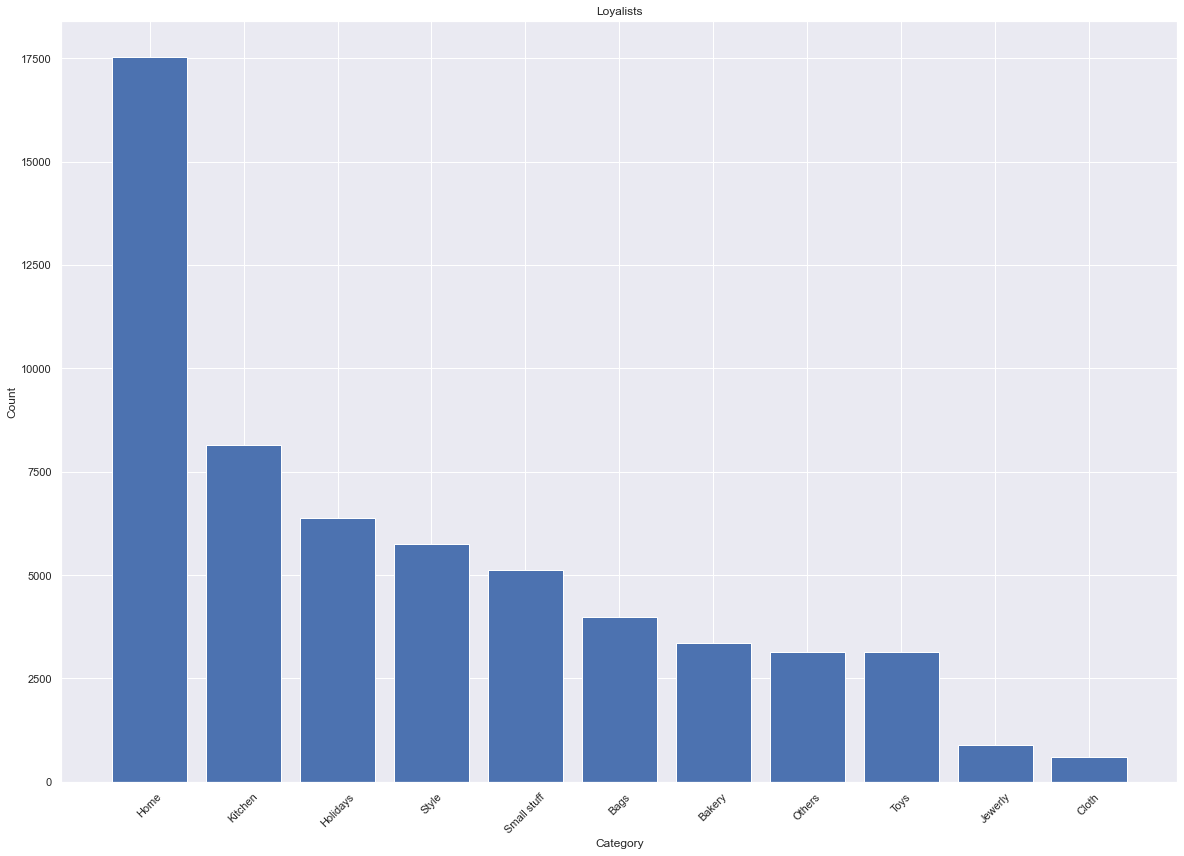

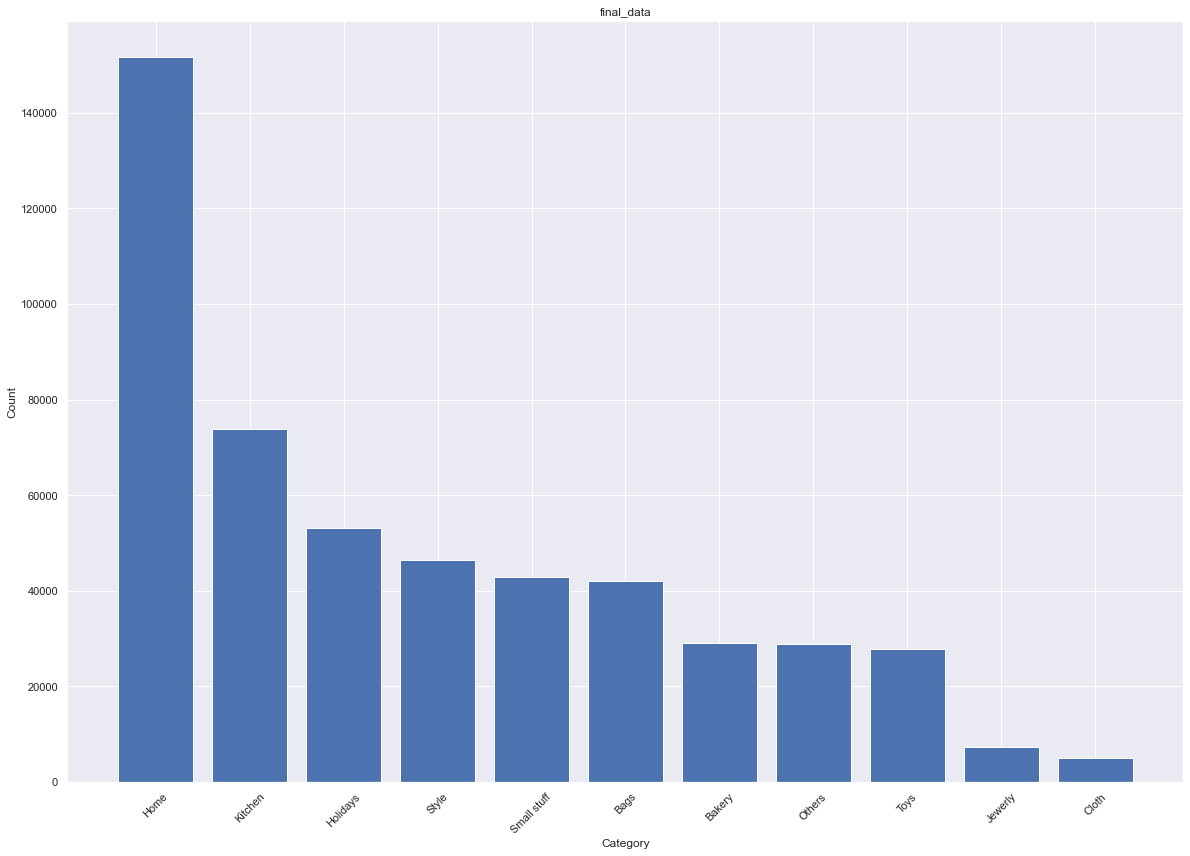

In [193]:
category_counts = merged_df_lost['Category'].value_counts()

category_counts_f = final_data['Category'].value_counts()


plt.bar(category_counts.index, category_counts.values)
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Loyalists')
plt.show()

plt.bar(category_counts_f.index, category_counts_f.values)
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('final_data')
plt.show()

In [194]:
merged_df_Dormant = merged_df[merged_df['RFM Category'] == 'Dormant Customers'] 

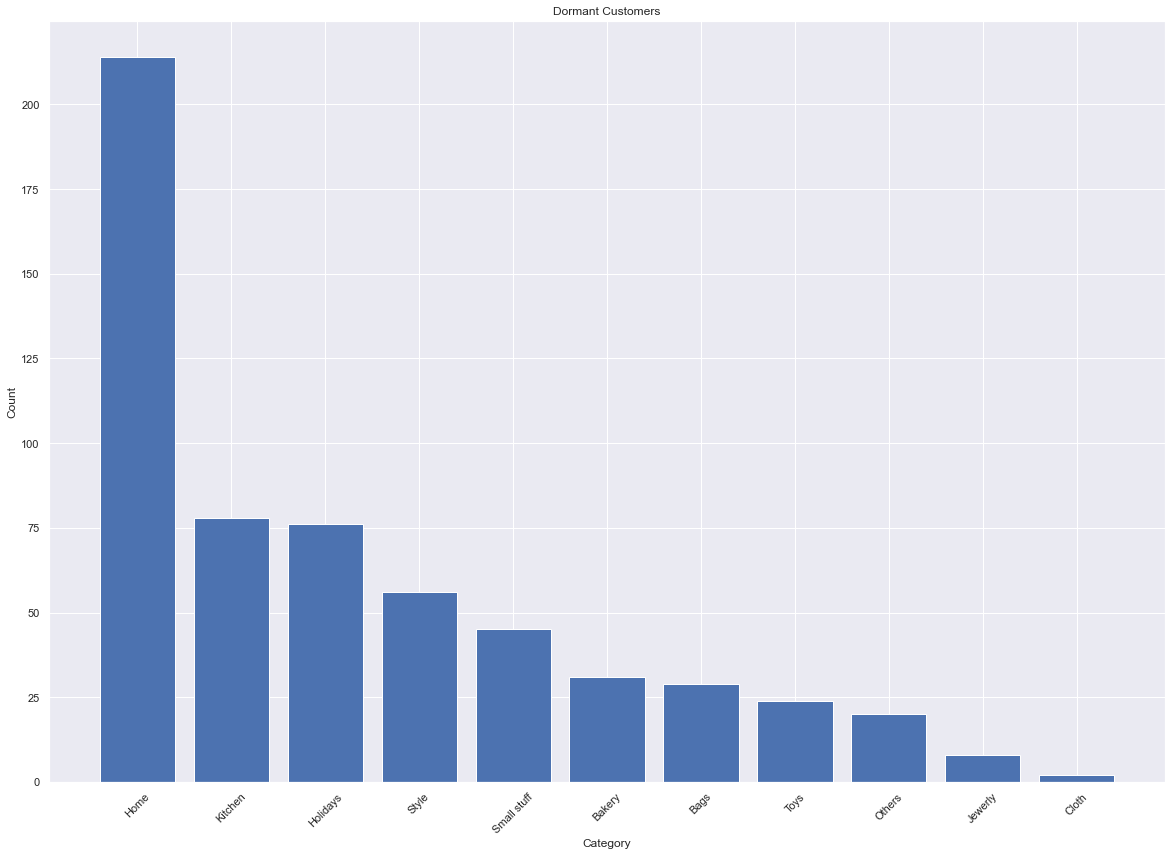

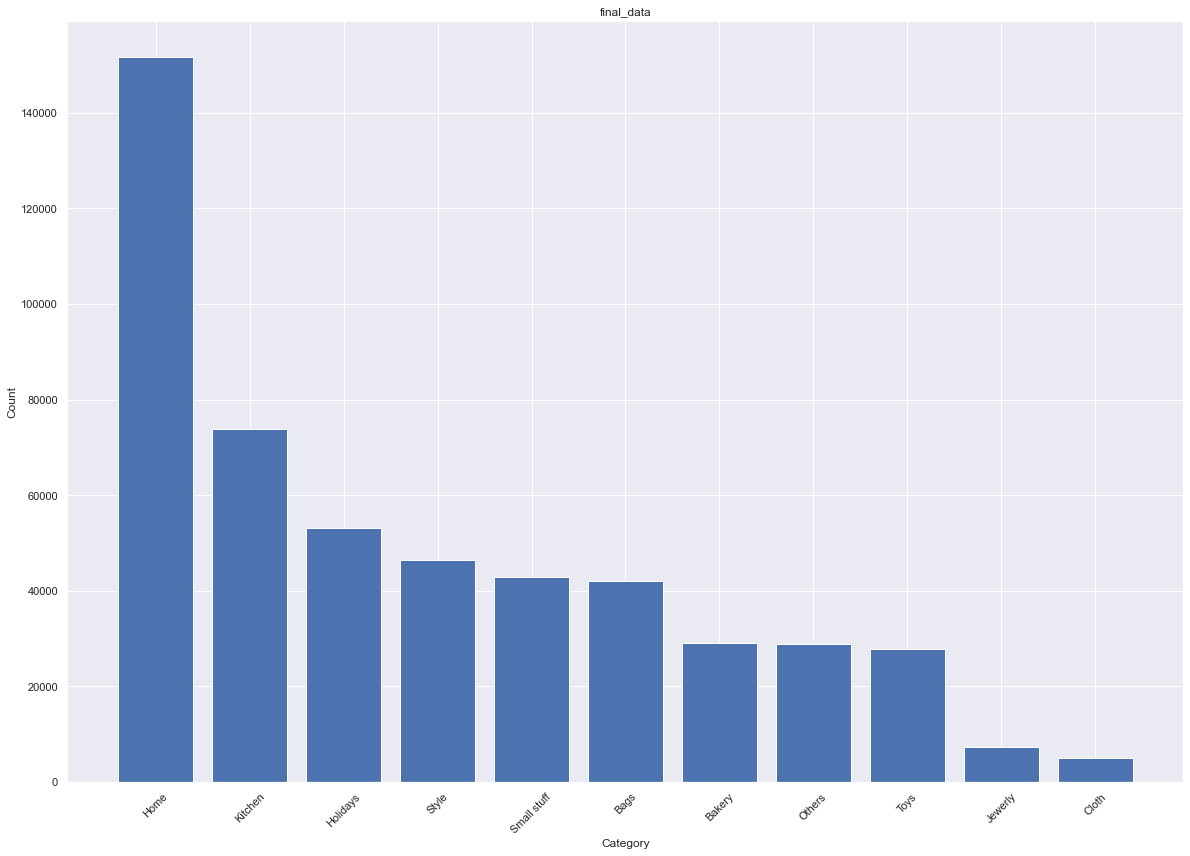

In [195]:
category_counts = merged_df_Dormant['Category'].value_counts()

category_counts_f = final_data['Category'].value_counts()


plt.bar(category_counts.index, category_counts.values)
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Dormant Customers')
plt.show()

plt.bar(category_counts_f.index, category_counts_f.values)
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('final_data')
plt.show()

##### We see that the distribution of product categories on top positions among customer categories is almost the same. Since our task is to analyze products, not customers and their behavior, we will stop there. It may be worth advising customers to develop different marketing moves for different customer groups. 

## Statistical theories

In this part of the analysis we're going to check whether there is statistically significant difference in the average revenue and average number of purchases from defferent seasons. we'll take Autumn and summer for our invastigation. 

- Difference in average revenue

alpha = 0.05

H0 - The average revenue from Autumn and Summer  has no difference
H1 - The average revenue from Autumn and Summer differs
- Difference in number of purchases by customer

alpha = 0.05

H0 - the number of purchases by customer doesn't differ for customers in Autumn and Summer
H1 - the number of purchases by customer is different for customers in Autumn and Summer
The distribution we have for revenue is not Normal, we also have significant outliers, meaning the data has anomalities. T-test and Z-Test won't be the right choice in this case. We will use non-parametrical Mann-Whitney test as it compares medians and not means.

In [253]:
final_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue,Average_Check,Year,Month,Category,Season
0,536365,85123A,white hanging heart t-light holder,6,2018-11-29 08:26:00,2.55,17850,15.30,113.62,2018,11,Home,Autumn
1,536365,71053,white metal lantern,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,2018,11,Home,Autumn
2,536365,84406B,cream cupid hearts coat hanger,8,2018-11-29 08:26:00,2.75,17850,22.00,113.62,2018,11,Holidays,Autumn
3,536365,84029G,knitted union flag hot water bottle,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,2018,11,Kitchen,Autumn
4,536365,84029E,red woolly hottie white heart.,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,2018,11,Kitchen,Autumn


In [254]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507871 entries, 0 to 507870
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   InvoiceNo      507871 non-null  object        
 1   StockCode      507871 non-null  object        
 2   Description    507871 non-null  object        
 3   Quantity       507871 non-null  int64         
 4   InvoiceDate    507871 non-null  datetime64[ns]
 5   UnitPrice      507871 non-null  float64       
 6   CustomerID     507871 non-null  int64         
 7   Revenue        507871 non-null  float64       
 8   Average_Check  507871 non-null  float64       
 9   Year           507871 non-null  int64         
 10  Month          507871 non-null  int64         
 11  Category       507871 non-null  object        
 12  Season         507871 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 54.2+ MB


In [255]:
Autumn = final_data.query('Season == "Autumn" and CustomerID != "0"')
Summer = final_data.query('Season == "Summer" and CustomerID != "0"')

 ### Creating Revenue samples.

In [256]:
Autumn_Revenue_list = Autumn['Revenue'].dropna().tolist()
Summer_Revenue_list = Summer['Revenue'].dropna().tolist()

In [257]:
print('The number of data points in Autumn list:', len(Autumn_Revenue_list))
print('The number of data points in Summer list:', len(Summer_Revenue_list))

The number of data points in Autumn list: 190930
The number of data points in Summer list: 104850


In [258]:
import random

In [259]:
random.shuffle(Autumn_Revenue_list)
Autumn_Revenue_sample = random.sample(Autumn_Revenue_list, 100000)

In [260]:
random.shuffle(Summer_Revenue_list)
Summer_Revenue_sample = random.sample(Summer_Revenue_list, 100000)

In [261]:
Autumn_Revenue_sample[0:5]

[17.700000000000003, 15.0, 66.08, 17.0, 1.95]

In [262]:
Summer_Revenue_sample[0:5]

[6.58, 8.26, 2.95, 12.72, 5.9]

### Creating purchases samples.

In [263]:
Autumn_purchases_list = Autumn.groupby('CustomerID')['InvoiceNo'].count().dropna().tolist()

Summer_purchases_list = Summer.groupby('CustomerID')['InvoiceNo'].count().dropna().tolist()

In [264]:
print('The number of data points in Autumn list:', len(Autumn_purchases_list))
print('The number of data points in Summer list:', len(Summer_purchases_list))

The number of data points in Autumn list: 3012
The number of data points in Summer list: 2059


In [265]:
random.shuffle(Autumn_purchases_list)
Autumn_purchases_sample = random.sample(Autumn_purchases_list, 2000)

In [266]:
random.shuffle(Summer_purchases_list)
Summer_purchases_sample = random.sample(Summer_purchases_list, 2000)
Summer_purchases_sample = Summer_purchases_list

In [267]:
Autumn_purchases_sample[0:5]

[9, 36, 25, 15, 71]

In [268]:
Summer_purchases_sample[0:5]

[425, 23, 7, 9, 1]

In [269]:
import scipy.stats as st
def test_season(sample1, sample2, alpha):

    stat, pval = st.mannwhitneyu(sample1, sample2)
    if pval < alpha:
        print('P-value: {0:0.9f}, reject H0: The null hypothesis is rejected, there is a statistically significant difference between seasons'.format(pval))
    else:
        print('P-value: {0:0.9f}, fail to reject H0: there is no statistical significance in the difference between conversions of the two groups'.format(pval))

In [270]:
test_season(Autumn_Revenue_sample, Summer_Revenue_sample, 0.05)

P-value: 0.000000084, reject H0: The null hypothesis is rejected, there is a statistically significant difference between seasons


In [271]:
test_season(Autumn_purchases_sample, Summer_purchases_sample, 0.05)

P-value: 0.000003482, reject H0: The null hypothesis is rejected, there is a statistically significant difference between seasons


#### Using the Mann-Whitney test we came to the conclusion that:
- We see that there is a statistically significant difference between the value of the average check in the Autumn and summer periods
- We cannot claim that there is a statistically significant difference between the number of purchases in the Autumn and summer periods

# CONCLUSION AND RECOMMENDATIONS

.
### We examined the data, eliminated the necessary data:
- some of the negative data in the Quantity column, those with a C in InvoiceNo and their matching ones in the positive Quantity, concluding that these are product returns that do not affect the distribution. 
- Missing data in Description
- obvious duplicates.
### After examining the strange values in StockCode, we identified and removed
- all values that in our opinion are irrelevant to the products. 
- we also created a separate table of such products for possible separate analysis. 
### We deleted about 5% of the data


 
###  By separating the product names into categories we see that
 - The distribution of products is very similar, between the data for 2018 only and the full data. For the first three and the last three categories, for all parameters tested. (Number of products sold, Revenue, and average check.
 - Number of products sold by category for both data slices: 
   - Highest number of units of product sold in Home, Kitchen and Holidays categories
   - Others, Jewerly and Cloth the least.
 - However, we can see that there is a slight change in the case of Revenue and average check.   The Style category, which is right in the middle in terms of the number of products sold, ranks third among the categories in terms of Revenue and average check. This suggests that perhaps the store should pay extra attention to this category, and perhaps increase the number of sales of these products. 
 - It's worth paying attention to the Home, Kitchen categories as sales leaders. 
 - The Cloth and Jewelly categories, which are tailgating in all respects, are also worth working on. 


### Distribution by season. 
- Remember, our database has data for November and December 2018, as well as for all of 2019. To ensure that November and December 2018 do not affect the distribution analysis, we use data for 2019 (Data_2019) and for 2018 separately, doing a distribution analysis between the 2 months. 
#### Conclusions for 2019:
- we see that in all metrics (counts, income, and average check), Fall is doing best. By a notable margin in all categories. 
- Behind Fall sales are better in Summer
- Winter and Spring compete for the worst spots.
- It may be worthwhile for businesses to come up with additional motivators, such as discounts or promotions for customers during these seasons (Winter and Spring). 
#### Conclusions for 2018:
we see a huge difference between the number of sales in November and December. It's possible that sales only started in November and that's why they are so small. There is no point in examining further, and we can only draw conclusions from the 2019 data. 
### Using the A priori function, we found that
there are products that sell better in pairs. We also looked at the seasonal difference and found that there are pairs of products in each season that would make more sense to sell together. Perhaps by studying Apriori's detailed tables by season, the store can offer customers pairs of products that they will buy more happily and with more benefit to the store
### Using the RFM module 
we categorized users into groups, depending on their behavior. then we did a comparative analysis of the distribution of purchases, depending on the user group. We see that the distribution of product categories among customer categories is almost the same. Since our task is to analyze products, not customers and their behavior, we will stop here. It may be worth advising customers to develop different marketing moves for different customer groups.
### Formulated and conducted statistical hypothesis that there is no statistically significant difference between seasonal sales.
We used the Mann-Whitney test  and disproved our null theory 
- We cannot claim that there is a statistically significant difference between the value of the average check in the fall and summer periods
- We cannot claim that there is a statistically significant difference between the number of purchases in the fall and summer periods
## RECOMMENDATIONS
1. the greatest amount of sales and revenue comes from the product categories of Home, Kitchen, Holidays, and Style. These are the most purchased products and it is important to have these products in sufficient quantity in the store. 

3. best sales across all product categories in the Fall, we need to understand why this is happening and be prepared for the Fall season
4. There are paired products that sell well together. (See Apriori section), it may be worth preparing offers on these paired products or putting together promotions, by season and paired products.
5. It might be worth preparing different promotions for different categories of users (see the RFM section)
      

In [272]:
final_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue,Average_Check,Year,Month,Category,Season
0,536365,85123A,white hanging heart t-light holder,6,2018-11-29 08:26:00,2.55,17850,15.30,113.62,2018,11,Home,Autumn
1,536365,71053,white metal lantern,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,2018,11,Home,Autumn
2,536365,84406B,cream cupid hearts coat hanger,8,2018-11-29 08:26:00,2.75,17850,22.00,113.62,2018,11,Holidays,Autumn
3,536365,84029G,knitted union flag hot water bottle,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,2018,11,Kitchen,Autumn
4,536365,84029E,red woolly hottie white heart.,6,2018-11-29 08:26:00,3.39,17850,20.34,113.62,2018,11,Kitchen,Autumn


In [274]:
final_data_to_tableau = final_data[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID',  'Revenue', 'Category', 'Month', 'Season', 'Average_Check']]
final_data_to_tableau

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue,Category,Month,Season,Average_Check
0,536365,85123A,white hanging heart t-light holder,6,2018-11-29 08:26:00,2.55,17850,15.30,Home,11,Autumn,113.62
1,536365,71053,white metal lantern,6,2018-11-29 08:26:00,3.39,17850,20.34,Home,11,Autumn,113.62
2,536365,84406B,cream cupid hearts coat hanger,8,2018-11-29 08:26:00,2.75,17850,22.00,Holidays,11,Autumn,113.62
3,536365,84029G,knitted union flag hot water bottle,6,2018-11-29 08:26:00,3.39,17850,20.34,Kitchen,11,Autumn,113.62
4,536365,84029E,red woolly hottie white heart.,6,2018-11-29 08:26:00,3.39,17850,20.34,Kitchen,11,Autumn,113.62
...,...,...,...,...,...,...,...,...,...,...,...,...
507866,581587,22613,pack of 20 spaceboy napkins,12,2019-12-07 12:50:00,0.85,12680,10.20,Toys,12,Winter,249.45
507867,581587,22899,children's apron dolly girl,6,2019-12-07 12:50:00,2.10,12680,12.60,Toys,12,Winter,249.45
507868,581587,23254,childrens cutlery dolly girl,4,2019-12-07 12:50:00,4.15,12680,16.60,Toys,12,Winter,249.45
507869,581587,23255,childrens cutlery circus parade,4,2019-12-07 12:50:00,4.15,12680,16.60,Toys,12,Winter,249.45


In [276]:
final_data_to_tableau.to_csv("final_to_tableau2.csv", index=False)

 [Tableau visaulization](https://public.tableau.com/app/profile/michael.birman/viz/Practicum_final/Dashboard1?publish=yes)

# PDF


 [PDF](https://drive.google.com/file/d/1I5x1O9m4dlHtBGn4-Sie4ov1Iv6vO6Uo/view?usp=sharing)

# References

## RFM

1.  [How RFM analysis is useful](https://serpstat.com/ru/blog/chem-polezen-rfm-analiz/)
2.  [Pareto's law](https://sendpulse.com/ru/blog/pareto-principle/)
3. [Divide the Customer Segment ](https://www.actioniq.com/blog/what-is-rfm-analysis/#:~:text=The%20%E2%80%9CRFM%E2%80%9D%20in%20RFM%20analysis,to%20act%20in%20the%20future.)

## Apriori

 1. [Apriori Algorithm](https://www.geeksforgeeks.org/apriori-algorithm/)
 2. [Basket Analisis](https://drive.google.com/drive/folders/1TtVJPkufPg9KN4GnW_1IE1VwT9GHZ8wi/)
 3.   [Apriori russian](https://biconsult.ru/products/algoritm-apriori-s-ispolzovaniem-python?ysclid=lglwtquke9980645854/)

## Other

1. [Data Prerpocessing](https://www.geeksforgeeks.org/data-preprocessing-machine-learning-python)
2. [Stemming and Lemmatization](https://medium.com/geekculture/stemming-and-lemmatization-in-python-using-nltk-df8fd800a13f) 
3. [String methods split() and join()](https://pythonist.ru/strokovye-metody-split-i-join-v-python/?ysclid=lglx9lnia4712142625)